# Collect Packages

In [ ]:
# Change num_trials to 500
!pip install neurogym
import neurogym as ngym
import torch
import torch.nn as nn
from torch.nn import init
import torch.optim as optim
from torch.optim import AdamW
import torch.nn.functional as F
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import pandas as pd
from pylab import *
from numpy import pi, arange

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 696.4/696.4 kB 9.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for neurogym: filename=neurogym-0.0.2-py3-none-any.whl size=118573 sha256=f156633536919fc0efb45af8b2a9e8a97da19f18403ceafa03878b9a50008404
  Stored in directory: /root/.cache/pip/wheels/f4/57/a7/66ed4eccf946052534253e4279438b97133b64facca56d4238
  Created wheel for gym: filename=gym-0.24.1-py3-none-any.whl size=793129 sha256=bd93d886ce5bda5f80c7e4feb01966457d373f7b541160c14e074a56b4fac1e5
  Stored in directory: /root/.cache/pip/wheels/c4/fb/19/388995b88cb551717a8dff40c889172cd12fadf994216a0a22
Successfully built neurogym gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successf

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(


# Assign Parameters For Task

In [ ]:
# Parameters
num_steps = 600  # Training steps
num_trials = 100 # Evaluation steps
log_interval = 1  # Logging interval

task_name = "PerceptualDecisionMaking-v0"
seq_len = 85 # To match the timing and dt.
batch_size = 16  # Batch size
hidden_size = 64 # might get better selectivity if this is lowered
timing = {
    'fixation': 200,    # Brief fixation to assess preparatory activity.
    'stimulus': 1000,   # Sufficient for evidence accumulation but not overly long.
    'decision': 500     # Tests quick and efficient decision-making.
}
dt = 20


# Collect The Data
Inspired from Cognitive_AI_lab4_brain_inspired_RNNs notebook

In [ ]:
# Define helper function to create datasets
def create_dataset(task_name, batch_size, seq_len, seed=None, **kwargs):
    if seed is not None:
        np.random.seed(seed)  # Set random seed for reproducibility
    dataset = ngym.Dataset(env=task_name, batch_size=batch_size, seq_len=seq_len, env_kwargs=kwargs)
    return dataset

hard_kwargs = {
    'cohs': [0.5, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0],
    'dt': dt,
    'timing': timing,
}
easy_kwargs = {
    'cohs': [70.0, 75.0, 80.0, 85.0, 90.0, 95.0, 100.0],
    'dt': dt,
    'timing': timing,
}

# Create datasets
hard_dataset = create_dataset(task_name, batch_size, seq_len, seed=42, **hard_kwargs)
easy_dataset = create_dataset(task_name, batch_size, seq_len, seed=126, **easy_kwargs)


# input-output shape from training dataset
train_inputs, train_targets = easy_dataset()
input_size = train_inputs.shape[-1]
output_size = np.max(train_targets) + 1

# Convert to PyTorch tensors (for testing purposes)
train_inputs = torch.from_numpy(train_inputs).type(torch.float32)
train_targets = torch.from_numpy(train_targets.flatten()).type(torch.long)

print(f"Input size: {input_size}, Output size: {output_size}")
print(f"Training Input Shape: {train_inputs.shape}, Targets Shape: {train_targets.shape}")

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


Input size: 3, Output size: 3
Training Input Shape: torch.Size([85, 16, 3]), Targets Shape: torch.Size([1360])


# Define The Standard Models

In [ ]:
class VanillaRNNNet(nn.Module):
    """Recurrent network using a simple Vanilla RNN layer with an output layer."""

    def __init__(self, input_size, hidden_size, output_size):
        super(VanillaRNNNet, self).__init__()
        self.hidden_size = hidden_size

        # Input-to-hidden and hidden-to-hidden transformations
        self.input_to_hidden = nn.Linear(input_size, hidden_size)
        self.hidden_to_hidden = nn.Linear(hidden_size, hidden_size)

        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        seq_len, batch_size, _ = x.size()
        hidden = torch.zeros(batch_size, self.hidden_size, device=x.device)  # Initial hidden state

        outputs = []
        hidden_states = []

        for t in range(seq_len):
            # Compute the new hidden state
            input_t = x[t]  # Shape: (batch_size, input_size)
            hidden = torch.tanh(self.input_to_hidden(input_t) + self.hidden_to_hidden(hidden))

            # Apply the output layer
            output = self.fc(hidden)
            outputs.append(output)
            hidden_states.append(hidden)

        # Stack outputs and hidden states for the sequence
        outputs = torch.stack(outputs, dim=0)  # Shape: (seq_len, batch_size, output_size)
        hidden_states = torch.stack(hidden_states, dim=0)  # Shape: (seq_len, batch_size, hidden_size)

        return outputs, hidden_states

# Define the RNNNet model
class LeakyRNN(nn.Module):
    """Leaky RNN using PyTorch's nn.Linear and explicit hidden state initialization."""

    def __init__(self, input_size, hidden_size, dt=None):
        super().__init__()
        self.hidden_size = hidden_size
        self.tau = 100
        self.alpha = nn.Parameter(torch.tensor(dt / self.tau if dt else 1.0), requires_grad=True)

        # Input-to-hidden and hidden-to-hidden transformations
        self.input_to_hidden = nn.Linear(input_size, hidden_size)
        self.hidden_to_hidden = nn.Linear(hidden_size, hidden_size)

    def forward(self, inputs):
        seq_len, batch_size, _ = inputs.size()
        device = inputs.device

        # Explicitly initialize hidden state as zeros
        hidden = torch.zeros(batch_size, self.hidden_size, device=device)

        outputs = []

        # Loop through time steps
        for t in range(seq_len):
            input_t = inputs[t]
            # Compute new hidden state with leaky integration
            new_hidden = torch.tanh(self.input_to_hidden(input_t) + self.hidden_to_hidden(hidden))
            hidden = self.alpha * new_hidden + (1 - self.alpha) * hidden
            outputs.append(hidden)

        # Stack outputs for all time steps
        outputs = torch.stack(outputs, dim=0)  # Shape: (seq_len, batch_size, hidden_size)
        return outputs


class RNNNet(nn.Module):
    """Recurrent network with LeakyRNN and an output layer."""

    def __init__(self, input_size, hidden_size, output_size, dt=None):
        super().__init__()
        self.rnn = LeakyRNN(input_size, hidden_size, dt)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_output = self.rnn(x)  # Hidden state, Shape: (seq_len, batch_size, hidden_size)
        output = self.fc(rnn_output)  # Apply output layer to each time step
        return output, rnn_output


class LSTMNet(nn.Module):
    """Recurrent network using an LSTM layer with an output layer."""

    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.0):
        super(LSTMNet, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Define LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=False, dropout=dropout)

        # Define output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_output, _ = self.lstm(x)  # lstm_output: (seq_len, batch_size, hidden_size)

        # Apply the output layer to each time step
        output = self.fc(lstm_output)  # output: (seq_len, batch_size, output_size)

        return output, lstm_output


# Define the TCNRNN

In [ ]:
class TCNRNN(nn.Module):
    """Recurrent network using a Vanilla RNN layer with time constant and noise."""

    def __init__(self, input_size, hidden_size, output_size, dt=None, tau=100, sigma_rec=0):
        """
        Args:
            input_size: Number of input features.
            hidden_size: Number of hidden units.
            output_size: Number of output features.
            dt: Time step for discretization. If None, defaults to 1.
            tau: Time constant for neuron dynamics.
            sigma_rec: Standard deviation of the recurrent noise.
        """
        super(TCNRNN, self).__init__()
        self.hidden_size = hidden_size
        self.tau = tau
        self.alpha = dt / tau if dt else 1  # Scaling factor for updates
        self.sigma_rec = torch.sqrt(torch.tensor(2 * self.alpha)) * sigma_rec  # Scaled noise term

        # Input-to-hidden and hidden-to-hidden transformations
        self.input_to_hidden = nn.Linear(input_size, hidden_size)
        self.hidden_to_hidden = nn.Linear(hidden_size, hidden_size)

        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        Args:
            x: Input tensor of shape (seq_len, batch_size, input_size).
        Returns:
            outputs: Output tensor of shape (seq_len, batch_size, output_size).
            hidden_states: Hidden states for all time steps of shape (seq_len, batch_size, hidden_size).
        """
        seq_len, batch_size, _ = x.size()
        hidden = torch.zeros(batch_size, self.hidden_size, device=x.device)  # Initial hidden state

        outputs = []
        hidden_states = []

        for t in range(seq_len):
            # Compute the new hidden state using time constant dynamics
            input_t = x[t]  # Shape: (batch_size, input_size)
            total_input = self.input_to_hidden(input_t) + self.hidden_to_hidden(hidden)
            new_hidden = torch.tanh(total_input)

            # Update hidden state using time constant dynamics and add noise
            hidden = hidden * (1 - self.alpha) + new_hidden * self.alpha
            noise = self.sigma_rec * torch.randn_like(hidden)  # Add scaled noise
            hidden += noise

            # Apply the output layer
            output = self.fc(hidden)
            outputs.append(output)
            hidden_states.append(hidden)

        # Stack outputs and hidden states for the sequence
        outputs = torch.stack(outputs, dim=0)  # Shape: (seq_len, batch_size, output_size)
        hidden_states = torch.stack(hidden_states, dim=0)  # Shape: (seq_len, batch_size, hidden_size)

        return outputs, hidden_states

# Define The EIRNN
Taken from Cognitive_AI_lab4_brain_inspired_RNNs notebook

In [ ]:
class EIRecLinear(nn.Module):

    r"""Recurrent E-I Linear transformation.

    This module implements a linear transformation with recurrent E-I dynamics,
    where part of the units are excitatory and the rest are inhibitory.

    Args:
        hidden_size: int, the number of units in the layer.
        e_prop: float between 0 and 1, the proportion of excitatory units.
        bias: bool, if True, adds a learnable bias to the output.
    """

    __constants__ = ['bias', 'hidden_size', 'e_prop']

    def __init__(self, hidden_size, e_prop, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.e_prop = e_prop
        self.e_size = int(e_prop * hidden_size) # Number of excitatory units
        self.i_size = hidden_size - self.e_size # Number of inhibitory units

        # Weight matrix for the recurrent connections
        self.weight = nn.Parameter(torch.Tensor(hidden_size, hidden_size))

        # Create a mask to define the E-I interactions
        # The mask has ones for E to E/I and negative ones for I to E/I, except the diagonal

        #First create a mask to remove the diagonal (matrix size hidden_size*hidden_size)
        mask_no_diag =  np.ones((hidden_size, hidden_size))
        np.fill_diagonal(mask_no_diag, 0)

        # Define the excitatory an inhibitory units with columns of 1s and -1s (use e_size and i_size)

        # Create an array of 1s with length e_size.
        e_cols = np.ones(self.e_size)
        # Create an array of -1s with length i_size.
        i_cols = -np.ones(self.i_size)
        # Concatenate the two arrays horizontally.
        ei_cols = np.concatenate([e_cols, i_cols])
        # Create a matrix by vertically stacking ei_cols (e_size + i_size) times.
        E_I_unit_list = np.tile(ei_cols, (self.e_size + self.i_size, 1))

        mask = mask_no_diag * E_I_unit_list
        # print(mask)

        self.mask = torch.tensor(mask, dtype=torch.float32)

        # Optionally add a bias term
        if bias:
            self.bias = nn.Parameter(torch.Tensor(hidden_size))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        # Initialize weights and biases
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        # Scale the weights for the excitatory neurons
        self.weight.data[:, :self.e_size] /= (self.e_size/self.i_size)

        # Initialize biases
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def effective_weight(self):
        # Apply the mask you have already created to the weights after applying rectification to get the effective weight
        # This ensures that weights from excitatory neurons are positive,
        # and weights from inhibitory neurons are negative.
        eff_W = F.relu(self.weight)*self.mask
        return eff_W

    def forward(self, input):
        # Apply the linear transformation using the effective weights and biases
        # The weights used are non-negative due to the absolute value in effective_weight.
        return F.linear(input, self.effective_weight(), self.bias)

class EIRNN(nn.Module):
    """E-I RNN.

    Reference:
        Song, H.F., Yang, G.R. and Wang, X.J., 2016.
        Training excitatory-inhibitory recurrent neural networks
        for cognitive tasks: a simple and flexible framework.
        PLoS computational biology, 12(2).

    Args:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons

    Inputs:
        input: (seq_len, batch, input_size)
        hidden: (batch, hidden_size)
        e_prop: float between 0 and 1, proportion of excitatory neurons
    """

    def __init__(self, input_size, hidden_size, dt=None,
                 e_prop=0.8, sigma_rec=0, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.e_size = int(hidden_size * e_prop)
        self.i_size = hidden_size - self.e_size
        self.num_layers = 1
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha
        self.oneminusalpha = 1 - alpha
        # Recurrent noise parameter, scaled by the discretization (sqrt(2*alpha)) and noise level (sigma_rec)
        # This adds stochasticity to the recurrent dynamics, possibly simulating biological neural variability
        self._sigma_rec = np.sqrt(2*alpha) * sigma_rec

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = EIRecLinear(hidden_size, e_prop=0.8)

    def init_hidden(self, input):
        batch_size = input.shape[1]
        return (torch.zeros(batch_size, self.hidden_size).to(input.device),
                torch.zeros(batch_size, self.hidden_size).to(input.device))

    def recurrence(self, input, hidden):
        """Recurrence helper."""
        state, output = hidden
        total_input = self.input2h(input) + self.h2h(output)

        state = state * self.oneminusalpha + total_input * self.alpha
        state += self._sigma_rec * torch.randn_like(state)
        output = torch.relu(state)
        return state, output

    def forward(self, input, hidden=None):
        """Propogate input through the network."""
        if hidden is None:
            hidden = self.init_hidden(input)

        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden[1])
        output = torch.stack(output, dim=0)
        return output, hidden

class EIRNNNet(nn.Module):
    """Recurrent network model.

    Args:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
        rnn: str, type of RNN, lstm, rnn, ctrnn, or eirnn
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Excitatory-inhibitory RNN
        self.rnn = EIRNN(input_size, hidden_size, **kwargs)
        self.fc = nn.Linear(self.rnn.e_size, output_size)

    def forward(self, x):
        rnn_activity, _ = self.rnn(x)
        rnn_e = rnn_activity[:, :, :self.rnn.e_size]
        out = self.fc(rnn_e)
        return out, rnn_activity


# Define the L1 Regulariser

In [ ]:
class Reg_L1(torch.nn.Module):
    """
    A regulariser that applies L1 regularisation to enforce sparsity
    in the recurrent kernel of an RNN.

    Calculation:
        reg_L1 * sum[|recurrent_kernel|]

    Attributes:
        reg_L1: Float; Weighting of L1 regularisation term.
    """

    def __init__(self, reg_L1=0.01):
        super(Reg_L1, self).__init__()
        self.reg_L1 = torch.tensor([reg_L1], dtype=torch.float32)

    def forward(self, x):
        """
        Compute the L1 regularisation term.

        Args:
            x (torch.Tensor): The weight matrix of the RNN.

        Returns:
            torch.Tensor: The L1 regularisation term.
        """
        # Compute the L1 norm
        L1_loss = self.reg_L1 * torch.sum(torch.abs(x))
        return L1_loss

    def _check_penalty_number(self, x):
        """
        Validate the penalty term.
        """
        if not isinstance(x, (float, int)):
            raise ValueError(
                f"Value: {x} is not a valid regularization penalty number. "
                "Expected an int or float value."
            )

    def get_config(self):
        """
        Return the configuration of the regulariser.
        """
        return {'reg_L1': float(self.reg_L1)}

# Define RFLO
Taken from Cognitive_AI_lab4_brain_inspired_RNNs notebook

In [ ]:
%matplotlib inline


def theta(x):
    return 0.5*(1 + sign(x))


def f(x):
    return np.tanh(x)


def df(x):
    return 1/np.cosh(10*np.tanh(x/10))**2  # the tanh prevents overflow


class RFLORNN:
    '''
    A recurrent neural network.

    Parameters:
    ----------
    n_in, n_rec, n_out : number of input, recurrent, and hidden units.

    h0 : The initial state vector of the RNN.

    tau_m : The network time constant, in units of timesteps.
    '''

    def __init__(self, n_in, n_rec, n_out, h0, tau_m=10):
        self.n_in = n_in
        self.n_rec = n_rec
        self.n_out = n_out
        self.h0 = h0
        self.tau_m = tau_m

        # Initialize weights:
        self.w_in = 0.1*(np.random.rand(n_rec, n_in) - 1)
        self.w_rec = np.random.randn(n_rec, n_rec)/n_rec**0.5
        self.w_out = 0.1*(2*np.random.rand(n_out, n_rec) - 1)/n_rec**0.5

        # Random error feedback matrix:
        self.b = np.random.randn(n_rec, n_out)/n_out**0.5


    def run_trial(self, x, y_, eta=[0.1, 0.1, 0.1],
                  learning=None, online_learning=False):
        '''
        Run the RNN for a single trial.

        Parameters:
        -----------
        x : The input to the network. x[t,i] is input from unit i at timestep t.

        y_ : The target RNN output, where y_[t,i] is output i at timestep t.

        eta : A list of 3 learning rates, for w_in, w_rec, and w_out,
            respectively.

        learning : Specify the learning algorithm with one of the following
            strings: 'rtrl', 'bptt', or 'rflo'. If None, run the network without
            learning.

        online_learning : If True (and learning is on), update weights at each
            timestep. If False (and learning is on), update weights only at the
            end of each trial. Online learning cannot be used with BPTT.

        Returns:
        --------
        y : The time-dependent network output. y[t,i] is output i at timestep t.

        h : The time-dependent RNN state vector. h[t,i] is unit i at timestep t.

        u : The inputs to RNN units (feedforward plus recurrent) at each
            timestep.
        '''

        # Boolean shorthands to specify learning algorithm:
        rtrl = learning is 'rtrl'
        bptt = learning is 'bptt'
        rflo = learning is 'rflo'

        [eta3, eta2, eta1] = eta  # learning rates for w_in, w_rec, and w_out
        t_max = np.shape(x)[0]  # number of timesteps

        dw_in, dw_rec, dw_out = 0, 0, 0  # changes to weights

        u = np.zeros((t_max, self.n_rec))  # input (feedforward plus recurrent)
        h = np.zeros((t_max, self.n_rec))  # time-dependent RNN activity vector
        h[0] = self.h0  # initial state
        y = np.zeros((t_max, self.n_out))  # RNN output
        err = np.zeros((t_max, self.n_out))  # readout error

        # If rflo, eligibility traces p and q should have rank 2; if rtrl, rank 3:
        if rtrl:
            p = np.zeros((self.n_rec, self.n_rec, self.n_rec))
            q = np.zeros((self.n_rec, self.n_rec, self.n_in))
        elif rflo:
            p = np.zeros((self.n_rec, self.n_rec))
            q = np.zeros((self.n_rec, self.n_in))

        for jj in range(self.n_rec):
            if rtrl:
                q[jj, jj, :] = df(u[0, jj])*x[0,:]/self.tau_m
            elif rflo:
                q[jj, :] = df(u[0, jj])*x[0,:]/self.tau_m

        for tt in range(t_max-1):
            u[tt+1] = np.dot(self.w_rec, h[tt]) + np.dot(self.w_in, x[tt+1])
            h[tt+1] = h[tt] + (-h[tt] + f(u[tt+1]))/self.tau_m
            y[tt+1] = np.dot(self.w_out, h[tt+1])
            err[tt+1] = y_[tt+1] - y[tt+1]  # readout error

            if rflo:
                p = (1-1/self.tau_m)*p
                q = (1-1/self.tau_m)*q
                p += np.outer(df(u[tt+1,:]), h[tt,:])/self.tau_m
                q += np.outer(df(u[tt+1,:]), x[tt,:])/self.tau_m
            elif rtrl:
                p = np.tensordot((1-1/self.tau_m)*np.eye(self.n_rec)
                    + df(u[tt+1])*self.w_rec/self.tau_m, p, axes=1)
                q = np.tensordot((1-1/self.tau_m)*np.eye(self.n_rec)
                    + df(u[tt+1])*self.w_rec/self.tau_m, q, axes=1)
                for jj in range(self.n_rec):
                    p[jj, jj, :] += df(u[tt+1, jj])*h[tt]/self.tau_m
                    q[jj, jj, :] += df(u[tt+1, jj])*x[tt+1]/self.tau_m

            if rflo and online_learning:
                dw_out = eta1/t_max*np.outer(err[tt+1], h[tt+1])
                dw_rec = eta2*np.outer(np.dot(self.b, err[tt+1]),
                                       np.ones(self.n_rec))*p/t_max
                dw_in = eta3*np.outer(np.dot(self.b, err[tt+1]),
                                      np.ones(self.n_in))*q/t_max
            elif rflo and not online_learning:
                dw_out += eta1/t_max*np.outer(err[tt+1], h[tt+1])
                dw_rec += eta2*np.outer(np.dot(self.b, err[tt+1]),
                                        np.ones(self.n_rec))*p/t_max
                dw_in += eta3*np.outer(np.dot(self.b, err[tt+1]),
                                       np.ones(self.n_in))*q/t_max
            elif rtrl and online_learning:
                dw_out = eta1/t_max*np.outer(err[tt+1], h[tt+1])
                dw_rec = eta2/t_max*np.tensordot(
                    np.dot(err[tt+1], self.w_out), p, axes=1)
                dw_in = eta3/t_max*np.tensordot(
                    np.dot(err[tt+1], self.w_out), q, axes=1)
            elif rtrl and not online_learning:
                dw_out += eta1/t_max*np.outer(err[tt+1], h[tt+1])
                dw_rec += eta2/t_max*np.tensordot(
                    np.dot(err[tt+1], self.w_out), p, axes=1)
                dw_in += eta3/t_max*np.tensordot(
                    np.dot(err[tt+1], self.w_out), q, axes=1)

            if online_learning and not bptt:
                self.w_out = self.w_out + dw_out
                self.w_rec = self.w_rec + dw_rec
                self.w_in = self.w_in + dw_in

        if bptt:  # backward pass for BPTT
            z = np.zeros((t_max, self.n_rec))
            z[-1] = np.dot((self.w_out).T, err[-1])
            for tt in range(t_max-1, 0, -1):
                z[tt-1] = z[tt]*(1 - 1/self.tau_m)
                z[tt-1] += np.dot((self.w_out).T, err[tt])
                z[tt-1] += np.dot(z[tt]*df(u[tt]), self.w_rec)/self.tau_m

                # Updates for the weights:
                dw_out += eta1*np.outer(err[tt], h[tt])/t_max
                dw_rec += eta2/(t_max*self.tau_m)*np.outer(z[tt]*df(u[tt]),
                                                            h[tt-1])
                dw_in += eta3/(t_max*self.tau_m)*np.outer(z[tt]*df(u[tt]),
                                                           x[tt])

        if not online_learning:  # wait until end of trial to update weights
            self.w_out = self.w_out + dw_out
            self.w_rec = self.w_rec + dw_rec
            self.w_in = self.w_in + dw_in

        return y, h, u


    def run_session(self, n_trials, x, y_, eta=[0.1, 0.1, 0.1],
                    learning=None, online_learning=False):
        '''
        Run the RNN for a session consisting of many trials.

        Parameters:
        -----------
        n_trials : Number of trials to run the RNN

        x : The time-dependent input to the RNN (same for each trial).

        y_ : The target RNN output (same for each trial).

        eta : A list of 3 learning rates, for w_in, w_rec, and w_out,
            respectively.

        learning : Specify the learning algorithm with one of the following
            strings: 'rtrl', 'bptt', or 'rflo'. If None, run the network without
            learning.

        online_learning : If True (and learning is on), update weights at each
            timestep. If False (and learning is on), update weights only at the
            end of each trial. Online learning cannot be used with BPTT.


        Returns:
        --------
        y : The RNN output.

        loss_list : A list with the value of the loss function for each trial.

        readout_alignment : The normalized dot product between the vectorized
            error feedback matrix and the readout matrix, as in Lillicrap et al
            (2016).
        '''

        t_max = np.shape(x)[0]  # number of timesteps
        loss_list = []
        readout_alignment = []

        # Flatten the random feedback matrix(rfm) to check for feedback alignment:
        # As a guide, the total number of elements in bT_flat will determined by n_rows(rfm)*n_cols(rfm)
        bT_flat = np.reshape((self.b).T,(np.shape(self.b)[0]*np.shape(self.b)[1]))

        bT_flat = bT_flat/norm(bT_flat)

        for ii in range(n_trials):
            y, h, u = self.run_trial(x, y_, eta, learning=learning,
                                     online_learning=online_learning)

            err = y_ - y
            loss = 0.5*np.mean(err**2)
            loss_list.append(loss)

            w_out_flat = np.reshape((self.w_out),(np.shape(self.w_out)[0]*np.shape(self.w_out)[1]))
            w_out_flat = w_out_flat/norm(w_out_flat)
            readout_alignment.append(np.dot(bT_flat, w_out_flat))
            print('\r'+str(ii+1)+'/'+str(n_trials)+'\t Err:'+str(loss), end='')

        return y, loss_list, readout_alignment


<>:78: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:79: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:80: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:78: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:79: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:80: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-61-6a9d6d27d574>:78: SyntaxWarning: "is" with a literal. Did you mean "=="?
  rtrl = learning is 'rtrl'
<ipython-input-61-6a9d6d27d574>:79: SyntaxWarning: "is" with a literal. Did you mean "=="?
  bptt = learning is 'bptt'
<ipython-input-61-6a9d6d27d574>:80: SyntaxWarning: "is" with a literal. Did you mean "=="?
  rflo = learning is 'rflo'


# Train RFLO
Inpired by the Cognitive_AI_lab4_brain_inspired_RNNs notebook and modified to match data

Training RFLO RNN with loss threshold stopping...
1/1	 Err:0.061686734077522204Trial 1/600, Average Train Loss: 0.1757
1/1	 Err:0.06823274327921293Trial 101/600, Average Train Loss: 0.0600
1/1	 Err:0.04655949866891269Trial 201/600, Average Train Loss: 0.0293
1/1	 Err:0.01359980325648367Trial 301/600, Average Train Loss: 0.0296
1/1	 Err:0.010916809816691875Trial 401/600, Average Train Loss: 0.0265
1/1	 Err:0.03206932525980549Trial 501/600, Average Train Loss: 0.0211
1/1	 Err:0.008293213015432227Training RFLO RNN with loss threshold stopping...
1/1	 Err:0.0730153098923636Trial 1/600, Average Train Loss: 0.6670
1/1	 Err:0.02841649437413228Trial 101/600, Average Train Loss: 0.0208
1/1	 Err:0.004446522368177204Trial 201/600, Average Train Loss: 0.0077
1/1	 Err:0.0038757709823524756Trial 301/600, Average Train Loss: 0.0122
1/1	 Err:0.01929264818481901Trial 401/600, Average Train Loss: 0.0139
1/1	 Err:0.005458033151927341Trial 501/600, Average Train Loss: 0.0105
1/1	 Err:0.017151329811362536

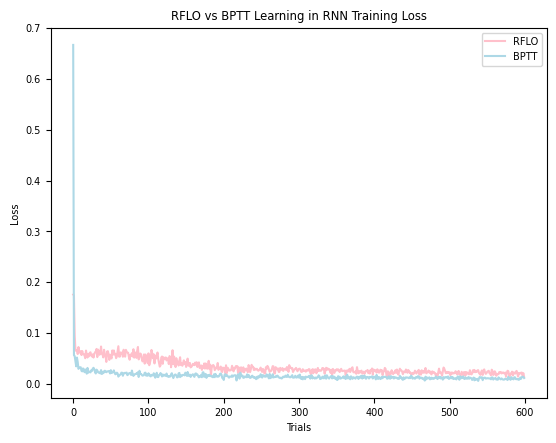

In [ ]:
import copy

def train_rflo_rnn(rflo_rnn, train_dataset, learn_type, max_trials=300, loss_threshold=0.8, eta=[0.03, 0.01, 0.03]):
    """
    Train the RFLO RNN on your dataset until the loss exceeds a specified threshold.

    Parameters:
    -----------
    rflo_rnn : RFLORNN instance
        The RFLO RNN to train.
    train_dataset : callable
        Function that returns (train_inputs, train_labels).
    learn_type : str
        Learning algorithm type ('rflo', 'rtrl', or 'bptt').
    max_trials : int
        Maximum number of training trials to run.
    loss_threshold : float
        Training stops if the average loss exceeds this value.
    eta : list
        Learning rates for [input weights, recurrent weights, output weights].

    Returns:
    --------
    best_rflo_rnn : RFLORNN instance
        The best-performing RFLO RNN (lowest loss).
    train_losses : list
        List of training losses per trial.
    """
    print("Training RFLO RNN with loss threshold stopping...")
    train_losses = []

    best_loss = float('inf')  # Initialize the best loss to infinity
    best_rflo_rnn = None  # Placeholder for the best-performing network

    for trial in range(max_trials):
        # Fetch a single input-output sequence (not a batch)
        train_inputs, train_labels = train_dataset()  # Shapes: (timesteps, batch_size, input_dim), (timesteps, batch_size)

        # # Normalize the inputs and outputs (optional but stabilizes training)
        # train_inputs = (train_inputs - np.mean(train_inputs)) / (np.std(train_inputs) + 1e-6)
        # train_labels = (train_labels - np.mean(train_labels)) / (np.std(train_labels) + 1e-6)

        # Loop over each sample in the batch (process one trial at a time)
        batch_losses = []
        for b in range(train_inputs.shape[1]):  # Iterate over the batch dimension
            inputs_single = train_inputs[:, b, :]  # Shape: (timesteps, input_dim)
            labels_single = train_labels[:, b][:, np.newaxis]  # Shape: (timesteps, 1)

            # Run a training trial
            _, loss_list, _ = rflo_rnn.run_session(
                n_trials=1,
                x=inputs_single,
                y_=labels_single,
                eta=eta,
                learning=learn_type,
                online_learning=False
            )

            # Record the loss for this trial
            batch_losses.append(loss_list[-1])

        # Average the loss over the batch
        avg_loss = np.mean(batch_losses)
        train_losses.append(avg_loss)

        if trial % 100 == 0:
          print(f"Trial {trial + 1}/{max_trials}, Average Train Loss: {avg_loss:.4f}")

        # # Check for improvement
        # if avg_loss < best_loss:
        #     best_loss = avg_loss  # Update the best loss
        #     best_rflo_rnn = copy.deepcopy(rflo_rnn)


        # Stop if the average loss exceeds the threshold
        if avg_loss > loss_threshold:
            best_rflo_rnn = copy.deepcopy(rflo_rnn)
            print(f"Stopping training as average loss exceeded {loss_threshold:.4f} at trial {trial + 1}.")
            break

        # Save last model
        best_rflo_rnn = copy.deepcopy(rflo_rnn)

    return best_rflo_rnn, train_losses



# Initialize RFLORNN
rflo_rnn = RFLORNN(input_size, hidden_size, output_size, h0=np.zeros(hidden_size))  # Adjust hidden size as needed

# Train RFLO RNN
rflo_rnn, train_losses_rflo = train_rflo_rnn(rflo_rnn, easy_dataset, learn_type='rflo', max_trials=num_steps)

# Initialize BPTT RNN
bptt_rnn = RFLORNN(input_size, hidden_size, output_size, h0=np.zeros(hidden_size))
# Train BPTT RNN
bptt_rnn, train_losses_bptt = train_rflo_rnn(rflo_rnn, easy_dataset, learn_type='bptt', max_trials=num_steps)

# Plot training losses
plt.rc('font', family='DejaVu Sans') # To avoid warning
plt.plot(train_losses_rflo, label='RFLO', color='pink')
plt.plot(train_losses_bptt, label='BPTT', color='lightblue')
plt.xlabel("Trials")
plt.ylabel("Loss")
plt.title("RFLO vs BPTT Learning in RNN Training Loss")
plt.legend()
plt.show()


# Evaluate RFLO
Inpired by the Cognitive_AI_lab4_brain_inspired_RNNs notebook and modified to match data

In [ ]:
def evaluate_rflo_rnn(rflo_rnn, dataset, num_trials):
    """
    Evaluate the trained RFLO RNN trial-by-trial.

    Args:
        rflo_rnn: Trained RFLO RNN model.
        dataset: Dataset to generate trials.
        num_trials: Number of trials to evaluate.

    Returns:
        perf: Average performance across trials.
        activity_dict: Dictionary storing RNN activities for each trial.
        trial_infos: Dictionary storing trial information, including correctness.
    """
    # Initialize variables for logging
    activity_dict = {}
    trial_infos = {}
    total_correct = 0

    # Reset the environment
    env = dataset.env
    env.reset(no_step=True)

    for trial in range(num_trials):
        # Sample a new trial from the environment
        trial_info = env.new_trial()
        ob, gt = env.ob, env.gt

        # Run the RFLO RNN for this trial
        y_pred, h_activity, _ = rflo_rnn.run_trial(ob, gt[:, np.newaxis], learning=False)

        # Compute performance
        choice = np.argmax(y_pred[-1, :])  # Read out the final choice
        correct = choice == gt[-1]  # Compare to ground truth

        # Record activity and trial information
        activity_dict[trial] = h_activity
        trial_infos[trial] = trial_info
        trial_infos[trial].update({'correct': correct})

        # Track correctness
        total_correct += correct

    # Compute average performance
    perf = total_correct / num_trials
    print(f"Evaluation complete. Average performance: {perf:.4f}")

    return perf, activity_dict, trial_infos



# Evaluate RFLO RNN
num_trials = 100
print('Easy Dataset:')
print('RFLO')
perf_rflo, activity_dict_rflo, trial_infos_rflo = evaluate_rflo_rnn(rflo_rnn, easy_dataset, num_trials)
print('BPTT')
perf_bptt, activity_dict_bptt, trial_infos_bptt = evaluate_rflo_rnn(bptt_rnn, easy_dataset, num_trials)

print('Hard Dataset:')
print('RFLO')
perf_rflo, activity_dict_rflo, trial_infos_rflo = evaluate_rflo_rnn(rflo_rnn, hard_dataset, num_trials)
print('BPTT')
perf_bptt, activity_dict_bptt, trial_infos_bptt = evaluate_rflo_rnn(bptt_rnn, hard_dataset, num_trials)

# model_path = "/content/drive/My Drive/best_rflo_rnn.pkl"
# with open(model_path, 'rb') as f:
#     best_rflo_rnn = pickle.load(f)

# model_path = "/content/drive/My Drive/best_bptt_rnn.pkl"
# with open(model_path, 'rb') as f:
#     bptt_rnn = pickle.load(f)

Easy Dataset:
RFLO
Evaluation complete. Average performance: 0.4800
BPTT
Evaluation complete. Average performance: 0.4900
Hard Dataset:
RFLO
Evaluation complete. Average performance: 0.8400
BPTT
Evaluation complete. Average performance: 0.8800


# Train The Model
Inpired by the Cognitive_AI_lab4_brain_inspired_RNNs notebook and modified to match data

In [ ]:
def train_model(net, train_dataset, test_dataset, num_steps, log_interval, regulariser=None, optimizer=None):
    if optimizer is None:
        optimizer = AdamW(net.parameters(), lr=0.01, weight_decay=1e-2)
    criterion = nn.CrossEntropyLoss()

    print('Training network...')
    running_loss = 0
    start_time = time.time()

    # Lists to store losses for plotting
    train_losses = []
    test_losses = []

    for step in range(num_steps):
        # Fetch a batch of training data
        train_inputs, train_labels = train_dataset()
        train_inputs = torch.from_numpy(train_inputs).type(torch.float32).to(device)
        train_labels = torch.from_numpy(train_labels.flatten()).type(torch.long).to(device)

        optimizer.zero_grad()
        outputs, rnn_activities = net(train_inputs)  # Updated to unpack predictions and activities

        # Reshape and compute loss
        outputs = outputs.view(-1, output_size)  # Flatten for loss computation
        loss = criterion(outputs, train_labels)

        if regulariser is not None:
            # Check if the model has the specific attribute indicating it's EIRNNNet
            if hasattr(net, 'rnn') and hasattr(net.rnn, 'h2h'):
                # Access recurrent weights for EIRNNNet
                recurrent_weights = net.rnn.h2h.weight
            else:
                # Default access for other models like VanillaRNNNet
                recurrent_weights = net.hidden_to_hidden.weight

            # Add L1 regularization term
            l1_loss = regulariser(recurrent_weights)  # Compute L1 regularization
            loss = loss + l1_loss  # Combine primary loss and regularization

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Compute running loss
        running_loss += loss.item()
        if (step + 1) % log_interval == 0:
            avg_loss = running_loss / log_interval
            train_losses.append(avg_loss)  # Store training loss
            running_loss = 0

            # Evaluate on test dataset
            test_inputs, test_labels = test_dataset()
            test_inputs = torch.from_numpy(test_inputs).type(torch.float32).to(device)
            test_labels = torch.from_numpy(test_labels.flatten()).type(torch.long).to(device)

            with torch.no_grad():
                test_outputs, _ = net(test_inputs)  # Ignore activities during test evaluation
                test_outputs = test_outputs.view(-1, output_size)
                test_loss = criterion(test_outputs, test_labels)
                test_losses.append(test_loss.item())  # Store test loss

    print('Training complete.')
    return net, train_losses, test_losses


# Initialize models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

VanillaRNNNet = VanillaRNNNet(input_size, hidden_size, output_size).to(device)
EIRNNNet = EIRNNNet(input_size, hidden_size, output_size).to(device)
TCNRNN = TCNRNN(input_size, hidden_size, output_size).to(device)
l1_regularizer = Reg_L1(reg_L1=0.01)


# Train the models and collect loss data
VanillaRNNNet, Vanilla_train_losses, Vanilla_test_losses = train_model(
    VanillaRNNNet, easy_dataset, easy_dataset, num_steps, log_interval
)
TCNRNN, TCN_train_losses, TCN_test_losses = train_model(
    TCNRNN, easy_dataset, easy_dataset, num_steps, log_interval
)
EIRNNNet, EIRNN_train_losses, EIRNN_test_losses = train_model(
    EIRNNNet, easy_dataset, easy_dataset, num_steps, log_interval
)
L1NormRNN, L1Norm_train_losses, L1Norm_test_losses = train_model(
    TCNRNN, easy_dataset, easy_dataset, num_steps, log_interval, regulariser=l1_regularizer
)
L1NormEIRNN, L1NormEIRNN_train_losses, L1NormEIRNN_test_losses = train_model(
    EIRNNNet, easy_dataset, easy_dataset, num_steps, log_interval, regulariser=l1_regularizer
)


Training network...
Training complete.
Training network...
Training complete.
Training network...
Training complete.
Training network...
Training complete.
Training network...
Training complete.


# Learning Curves

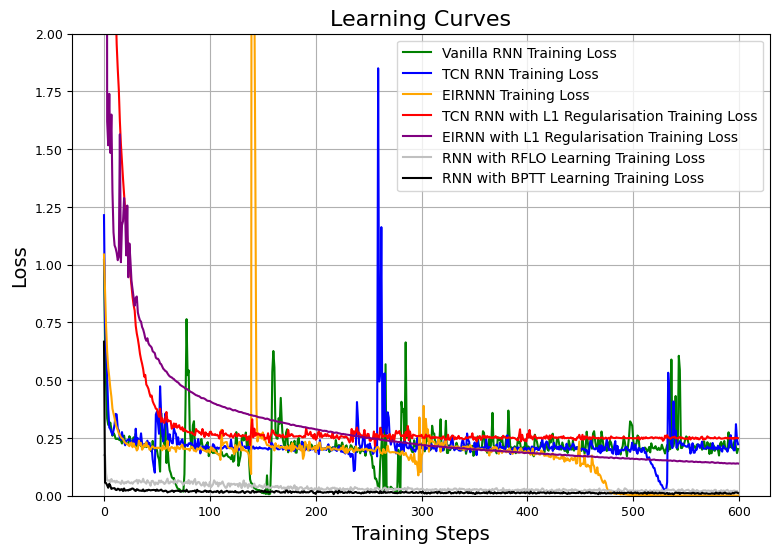

In [ ]:
# Plot learning curves
plt.rc('font', family='DejaVu Sans') # To avoid warning
# subplot
plt.figure(figsize=(9, 6))

plt.plot(Vanilla_train_losses, label='Vanilla RNN Training Loss', color='green')
plt.plot(TCN_train_losses, label='TCN RNN Training Loss', color='blue')
plt.plot(EIRNN_train_losses, label='EIRNNN Training Loss', color='orange')
plt.plot(L1Norm_train_losses, label='TCN RNN with L1 Regularisation Training Loss', color='red')
plt.plot(L1NormEIRNN_train_losses, label='EIRNN with L1 Regularisation Training Loss', color='purple')
plt.plot(train_losses_rflo, label='RNN with RFLO Learning Training Loss', color='silver')
plt.plot(train_losses_bptt, label='RNN with BPTT Learning Training Loss', color='black')

plt.ylim(0, 2)

# Add bigger fonts for title, labels, and legend
plt.xlabel('Training Steps', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Learning Curves', fontsize=16)
plt.legend(fontsize=10)  # Adjust legend font size
plt.tick_params(axis='both', which='major', labelsize=9)
plt.grid()

plt.show()


# Test The Model
Inpired by the Cognitive_AI_lab4_brain_inspired_RNNs notebook and modified to match data

In [ ]:
def evaluate_model(net, dataset, num_trials):
    """
    Evaluate the trained model trial-by-trial, mimicking the original function's behavior.

    Args:
        net: Trained PyTorch model.
        dataset: Dataset (ngym.Dataset) to generate trials.
        num_trials: Number of trials to evaluate.

    Returns:
        perf: Average performance across trials.
        activity_dict: Dictionary storing RNN activities for each trial.
        trial_infos: Dictionary storing trial information, including correctness.
    """
    net.eval()  # Set model to evaluation mode
    device = next(net.parameters()).device  # Get the device the model is on

    # Initialize variables for logging
    activity_dict = {}  # Recording RNN activities
    trial_infos = {}  # Recording trial information
    total_correct = 0

    # Reset the environment
    env = dataset.env
    env.reset(no_step=True)

    for i in range(num_trials):
        # Sample a new trial from the environment
        trial_info = env.new_trial()
        ob, gt = env.ob, env.gt  # Observation and ground truth for this trial
        # print(f"Sequence Length: {len(env.ob)}")
        # print(f"Fixation Period: {env.timing['fixation']}")
        # print(f"Stimulus Period: {env.timing['stimulus']}")
        # print(f"Delay Period: {env.timing['delay']}")
        # print(f"Decision Period: {env.timing['decision']}")

        # Convert observation to PyTorch tensor and add batch dimension
        inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float32).to(device)

        # Run the network for this trial
        with torch.no_grad():
            action_pred, rnn_activity = net(inputs)  # Predictions and RNN activities

        # Compute performance
        action_pred = action_pred.detach().cpu().numpy()[:, 0, :]  # Remove batch dimension
        choice = np.argmax(action_pred[-1, :])  # Read out the final choice
        correct = choice == gt[-1]  # Compare to ground truth

        # Record activity and trial information
        rnn_activity = rnn_activity[:, 0, :].detach().cpu().numpy()  # Remove batch dimension
        activity_dict[i] = rnn_activity
        trial_infos[i] = trial_info  # Copy trial info
        trial_infos[i].update({'correct': correct})  # Add correctness to trial info

        # Track correctness
        total_correct += correct

    # Compute average performance
    perf = total_correct / num_trials

    print(f"Evaluation complete. Average performance: {perf:.4f}")
    return perf, activity_dict, trial_infos



# Call the evaluation function
print('Hard Dataset:')
print('VanillaRNNNet:')
Vanilla_performance, Vanilla_activity_dict, Vanilla_trial_infos = evaluate_model(VanillaRNNNet, hard_dataset, num_trials)
print('TCNRNN:')
TCN_performance, TCN_activity_dict, TCN_trial_infos = evaluate_model(TCNRNN, hard_dataset, num_trials)
print('EIRNNNet:')
EIRNN_performance, EIRNN_activity_dict, EIRNN_trial_infos = evaluate_model(EIRNNNet, hard_dataset, num_trials)
print('L1NormTCNRNN:')
L1NormRNN_performance, L1NormRNN_activity_dict, L1NormRNN_trial_infos = evaluate_model(L1NormRNN, hard_dataset, num_trials)
print('L1NormEIRNN:')
L1NormEIRNN_performance, L1NormEIRNN_activity_dict, L1NormEIRNN_trial_infos = evaluate_model(L1NormEIRNN, hard_dataset, num_trials)

print('Easy Dataset:')
print('VanillaRNNNet:')
easy_Vanilla_performance, easy_Vanilla_activity_dict, easy_Vanilla_trial_infos = evaluate_model(VanillaRNNNet, easy_dataset, num_trials)
print('TCNRNN:')
easy_TCN_performance, easy_TCN_activity_dict, easy_TCN_trial_infos = evaluate_model(TCNRNN, easy_dataset, num_trials)
print('EIRNNNet:')
easy_EIRNN_performance, easy_EIRNN_activity_dict, easy_EIRNN_trial_infos = evaluate_model(EIRNNNet, easy_dataset, num_trials)
print('L1NormTCNRNN:')
easy_L1NormRNN_performance, easy_L1NormRNN_activity_dict, easy_L1NormRNN_trial_infos = evaluate_model(L1NormRNN, easy_dataset, num_trials)
print('L1NormEIRNN:')
easy_L1NormEIRNN_performance, easy_L1NormEIRNN_activity_dict, easy_L1NormEIRNN_trial_infos = evaluate_model(L1NormEIRNN, easy_dataset, num_trials)

Hard Dataset:
VanillaRNNNet:
Evaluation complete. Average performance: 0.4100
TCNRNN:
Evaluation complete. Average performance: 0.4500
EIRNNNet:
Evaluation complete. Average performance: 0.5400
L1NormTCNRNN:
Evaluation complete. Average performance: 0.5500
L1NormEIRNN:
Evaluation complete. Average performance: 0.6000
Easy Dataset:
VanillaRNNNet:
Evaluation complete. Average performance: 0.5100
TCNRNN:
Evaluation complete. Average performance: 0.4400
EIRNNNet:
Evaluation complete. Average performance: 1.0000
L1NormTCNRNN:
Evaluation complete. Average performance: 0.5400
L1NormEIRNN:
Evaluation complete. Average performance: 1.0000


# Ground Truth Activies
Inpired by the Cognitive_AI_lab4_brain_inspired_RNNs notebook and modified to match data

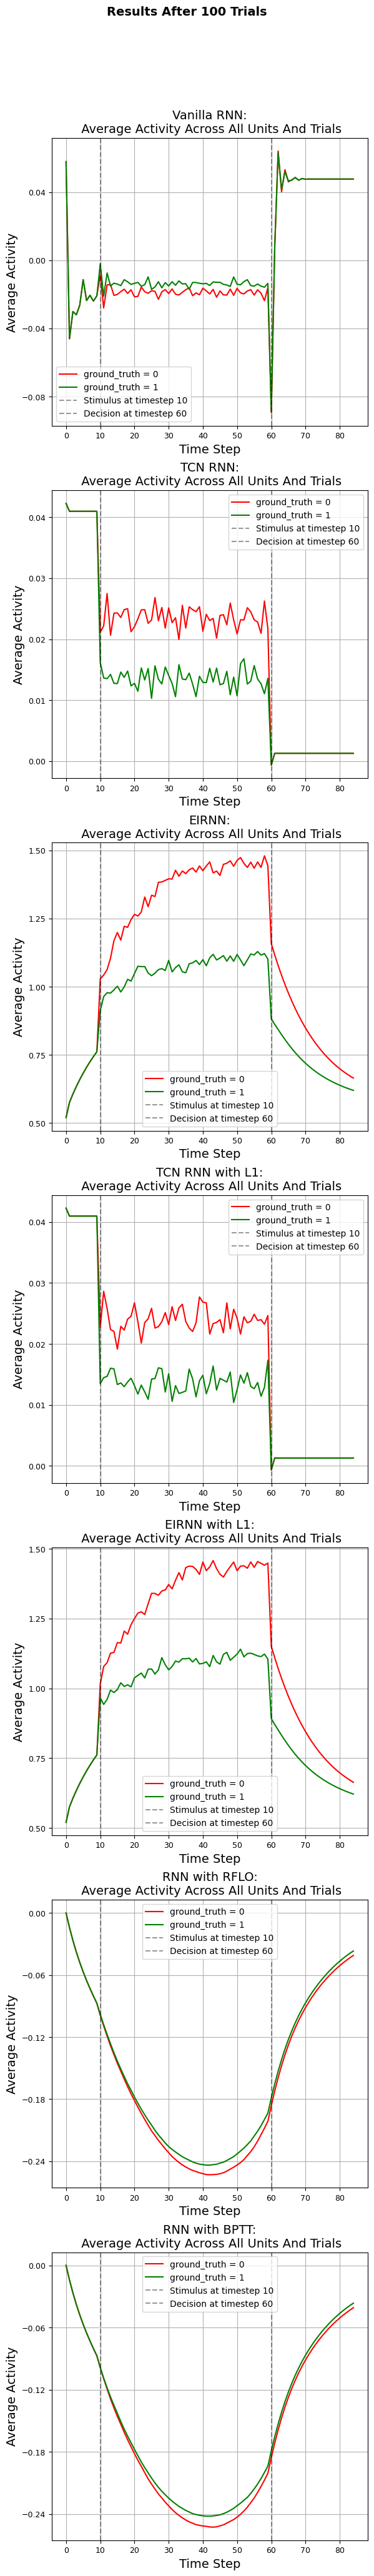

In [ ]:
def compute_average_activity(activity_dict, trial_infos, split_key='ground_truth', split_value=1):
    """
    Compute the average activity for trials split by a specific criterion.

    Args:
        activity_dict: Dictionary mapping trial indices to activity arrays (time_steps, hidden_size).
        trial_infos: Dictionary mapping trial indices to trial metadata (e.g., ground_truth).
        split_key: Key in the trial metadata used for splitting trials (e.g., 'ground_truth').
        split_value: Value of the split key to filter trials (e.g., 1 for ground_truth=1).

    Returns:
        mean_activity: Average activity across trials where trial_info[split_key] == split_value.
    """
    # Filter trials based on the split criterion
    selected_trials = [i for i, info in trial_infos.items() if info[split_key] == split_value]

    # Compute the mean activity for the selected trials
    if selected_trials:
        selected_activities = np.mean([activity_dict[i] for i in selected_trials], axis=0)
        mean_activity = np.mean(selected_activities, axis=1)  # Average across units
    else:
        # Handle case where no trials match the split
        mean_activity = None
        print(f"No trials found for {split_key}={split_value}")

    return mean_activity

import matplotlib.ticker as ticker

def plot_activity_by_ground_truth(
    models, split_key, split_values, activities_0, activities_1, titles,
    suptitle="Average Activity by Ground Truth", timing=None, dt=None,
    title_fontsize=14, legend_fontsize=10, tick_label_fontsize=9, axis_label_fontsize=14, suptitle_fontsize=14
):
    """
    Create a single-column subplot visualization of average activity split by ground truth (0 or 1),
    with vertical lines marking key phases based on timing and dt.

    Args:
        models: List of model names (e.g., ['Vanilla RNN', 'Leaky RNN', ...]).
        activities_0: List of average activities for ground_truth=0 for each model.
        activities_1: List of average activities for ground_truth=1 for each model.
        titles: List of subplot titles for each model.
        suptitle: Main title for the entire plot.
        timing: Dictionary with 'fixation', 'stimulus', and 'decision' times in ms.
        dt: Time step size in ms.
        title_fontsize: Font size for subplot titles.
        legend_fontsize: Font size for legend.
        tick_label_fontsize: Font size for tick labels.
        axis_label_fontsize: Font size for x and y axis labels.
        suptitle_fontsize: Font size for the main title.
    """
    if timing is None or dt is None:
        raise ValueError("Both `timing` and `dt` must be provided.")

    # Calculate the transition points in terms of time steps
    stimulus_start = timing['fixation'] / dt
    decision_start = (timing['fixation'] + timing['stimulus']) / dt

    num_models = len(models)
    rows = num_models  # One column, so rows equal to the number of models
    cols = 1

    fig, axes = plt.subplots(rows, cols, figsize=(6, rows * 6))

    # If there's only one model, `axes` won't be iterable, so handle it
    if num_models == 1:
        axes = [axes]

    for i, model in enumerate(models):
        ax = axes[i]
        if activities_0[i] is not None:
            ax.plot(activities_0[i], label=f'{split_key} = {split_values[0]}', color='red')
        if activities_1[i] is not None:
            ax.plot(activities_1[i], label=f'{split_key} = {split_values[1]}', color='green')

        # Add vertical lines for stimulus and decision phases
        ax.axvline(stimulus_start, color='black', linestyle='--', label=f'Stimulus at timestep {int(stimulus_start)}', alpha=0.4)
        ax.axvline(decision_start, color='black', linestyle='--', label=f'Decision at timestep {int(decision_start)}', alpha=0.4)

        # Set title and axis labels with font size
        ax.set_title(titles[i], fontsize=title_fontsize)
        ax.set_xlabel('Time Step', fontsize=axis_label_fontsize)
        ax.set_ylabel('Average Activity', fontsize=axis_label_fontsize)

        # Configure tick label font size
        ax.tick_params(axis='both', which='major', labelsize=tick_label_fontsize)

        # Configure legend font size
        ax.legend(fontsize=legend_fontsize)
        ax.grid()

        # Configure major ticks
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))  # At most 5 major ticks

    # Add an overall title
    fig.suptitle(suptitle, fontsize=suptitle_fontsize, fontweight='bold')

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Make room for suptitle
    plt.show()





split_key='ground_truth'
split_values = [0,1]
# split_key='correct'
# split_values = [True,False]
# Vanilla RNN
vanilla_activity_1 = compute_average_activity(Vanilla_activity_dict, Vanilla_trial_infos, split_key=split_key, split_value=split_values[0])
vanilla_activity_0 = compute_average_activity(Vanilla_activity_dict, Vanilla_trial_infos, split_key=split_key, split_value=split_values[1])
# EIRNN
eirnn_activity_1 = compute_average_activity(EIRNN_activity_dict, EIRNN_trial_infos, split_key=split_key, split_value=split_values[0])
eirnn_activity_0 = compute_average_activity(EIRNN_activity_dict, EIRNN_trial_infos, split_key=split_key, split_value=split_values[1])
# TCNoise
TCN_activity_1 = compute_average_activity(TCN_activity_dict, TCN_trial_infos, split_key=split_key, split_value=split_values[0])
TCN_activity_0 = compute_average_activity(TCN_activity_dict, TCN_trial_infos, split_key=split_key, split_value=split_values[1])
# L1Norm
L1Norm_activity_1 = compute_average_activity(L1NormRNN_activity_dict, L1NormRNN_trial_infos, split_key=split_key, split_value=split_values[0])
L1Norm_activity_0 = compute_average_activity(L1NormRNN_activity_dict, L1NormRNN_trial_infos, split_key=split_key, split_value=split_values[1])
# L1NormEIRNN
L1NormEIRNN_activity_1 = compute_average_activity(L1NormEIRNN_activity_dict, L1NormEIRNN_trial_infos, split_key=split_key, split_value=split_values[0])
L1NormEIRNN_activity_0 = compute_average_activity(L1NormEIRNN_activity_dict, L1NormEIRNN_trial_infos, split_key=split_key, split_value=split_values[1])
# RFLO
rflo_activity_1 = compute_average_activity(activity_dict_rflo, trial_infos_rflo, split_key=split_key, split_value=split_values[0])
rflo_activity_0 = compute_average_activity(activity_dict_rflo, trial_infos_rflo, split_key=split_key, split_value=split_values[1])
# BPTT
bptt_activity_1 = compute_average_activity(activity_dict_bptt, trial_infos_bptt, split_key=split_key, split_value=split_values[0])
bptt_activity_0 = compute_average_activity(activity_dict_bptt, trial_infos_bptt, split_key=split_key, split_value=split_values[1])


# Plot using the function
plot_activity_by_ground_truth(
    models=['Vanilla RNN', 'TCN RNN', 'EIRNN', 'TCN RNN with L1', 'EIRNN with L1', 'RNN with RFLO', 'RNN with BPTT'],
    split_key = split_key,
    split_values = split_values,
    activities_0=[vanilla_activity_0, TCN_activity_0, eirnn_activity_0, L1Norm_activity_0, L1NormEIRNN_activity_0, rflo_activity_0, bptt_activity_0],
    activities_1=[vanilla_activity_1, TCN_activity_1, eirnn_activity_1, L1Norm_activity_1, L1NormEIRNN_activity_1, rflo_activity_1, bptt_activity_1],
    titles=[
        'Vanilla RNN:\n Average Activity Across All Units And Trials',
        'TCN RNN:\n Average Activity Across All Units And Trials',
        'EIRNN:\n Average Activity Across All Units And Trials',
        'TCN RNN with L1:\n Average Activity Across All Units And Trials',
        'EIRNN with L1:\n Average Activity Across All Units And Trials',
        'RNN with RFLO:\n Average Activity Across All Units And Trials',
        'RNN with BPTT:\n Average Activity Across All Units And Trials'
    ],
    suptitle=f"Results After {num_trials} Trials",
    timing=timing,
    dt=dt
)

# PCA
Inpired by the Cognitive_AI_lab6_RNN_analysis notebook and modified to match data

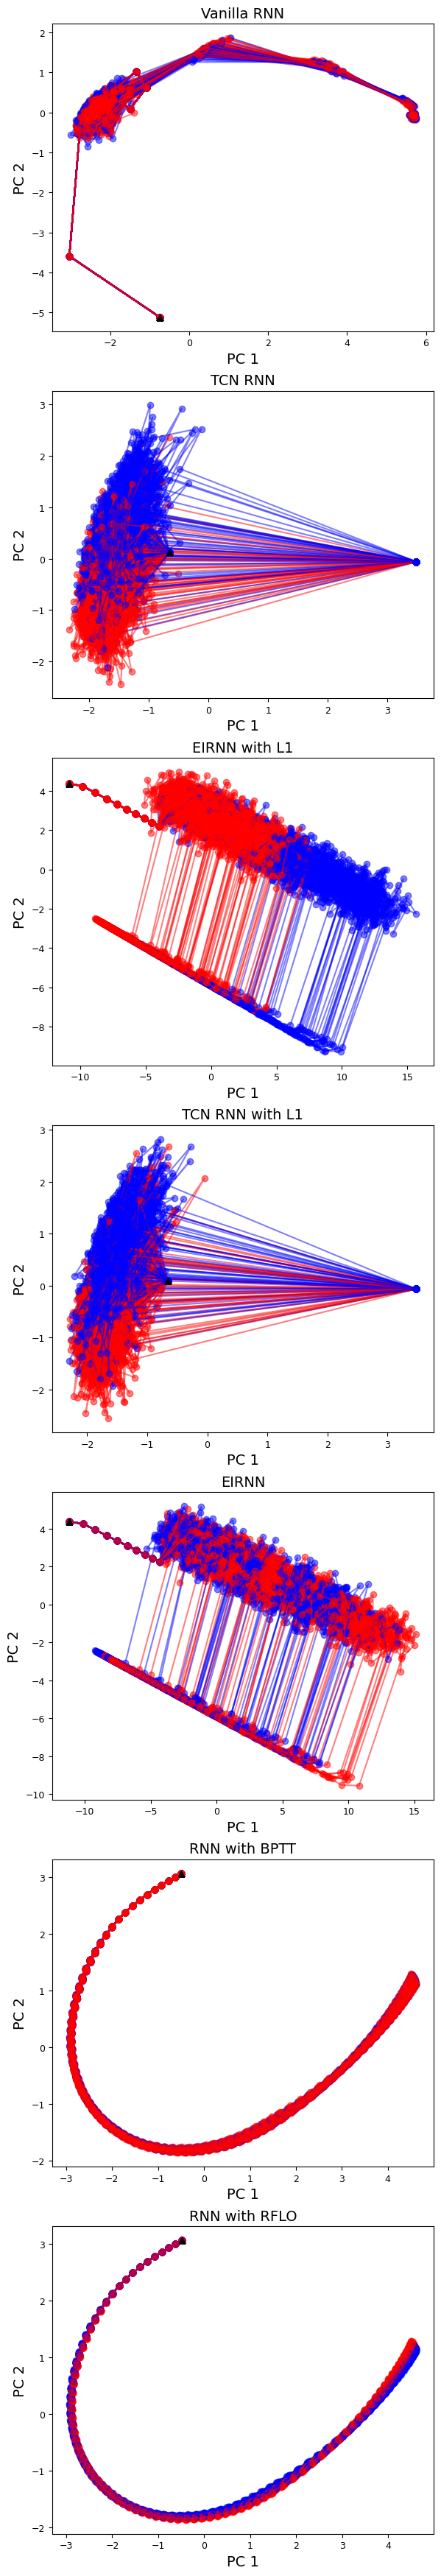

                 Intra-class 0  Intra-class 1  Inter-class  Choice Separation
    Vanilla RNN           3.29           3.70         3.52               0.24
        TCN RNN           2.22           2.43         2.34               0.24
          EIRNN           5.43           5.35         5.44               0.57
TCN RNN with L1           2.44           2.31         2.40               0.30
  EIRNN with L1           8.13           8.24         8.30               0.78
  RNN with RFLO           3.53           3.71         3.64               0.16
  RNN with BPTT           3.46           3.66         3.67               0.74


In [ ]:
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances

def compare_pca_by_condition(activity_dicts, trial_infos, labels, num_trials=100):
    """
    Perform PCA on hidden activities and compare by condition across models.

    Args:
        activity_dicts: List of activity dictionaries for each model.
        trial_infos: List of trial info dictionaries for each model.
        labels: List of labels for each model (e.g., ['Leaky RNN', 'LSTM']).
        num_trials: Number of trials to include in PCA.
    """
    colors = ['red', 'blue']  # Ground truth colors
    num_models = len(activity_dicts)

    # Create vertically stacked subplots (one column)
    fig, axes = plt.subplots(num_models, 1, figsize=(6, 5 * num_models))  # Narrower and taller plots

    # Ensure `axes` is iterable for a single subplot case
    if num_models == 1:
        axes = [axes]

    for model_idx, (activity_dict, trial_info, label) in enumerate(zip(activity_dicts, trial_infos, labels)):
        ax = axes[model_idx]

        # Concatenate activity for PCA
        activity = np.concatenate([activity_dict[i] for i in range(num_trials)], axis=0)
        pca = PCA(n_components=2)
        pca.fit(activity)

        # Transform and plot by condition
        for i in range(num_trials):
            activity_pc = pca.transform(activity_dict[i])
            trial = trial_info[i]
            color = colors[trial['ground_truth']]

            # Plot the line connecting points
            ax.plot(activity_pc[:, 0], activity_pc[:, 1], color=color, alpha=0.5, marker='o')

            # Mark the trial start with a distinct marker
            ax.plot(activity_pc[0, 0], activity_pc[0, 1], '^', color='black')

        # Add labels and title
        ax.set_title(label, fontsize=14)
        ax.set_xlabel('PC 1', fontsize=14)
        ax.set_ylabel('PC 2', fontsize=14)
        ax.tick_params(axis='both', labelsize=9)

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()


def compute_cluster_metrics(activity_dict, trial_info, num_trials=100):
    # Concatenate activity for PCA
    activity = np.concatenate([activity_dict[i] for i in range(num_trials)], axis=0)
    pca = PCA(n_components=2)
    activity_pc = pca.fit_transform(activity)

    # Separate activities by choice
    choice_0 = np.array([activity_pc[i] for i in range(num_trials) if trial_info[i]['ground_truth'] == 0])
    choice_1 = np.array([activity_pc[i] for i in range(num_trials) if trial_info[i]['ground_truth'] == 1])

    # Intra-class (compactness)
    intra_0 = np.mean(pairwise_distances(choice_0))
    intra_1 = np.mean(pairwise_distances(choice_1))

    # Inter-class (overlap)
    inter = np.mean(pairwise_distances(choice_0, choice_1))

    return intra_0, intra_1, inter

def compute_pca_choice_separation(activity_dict, trial_info, num_trials=100):
    """
    Compute the separation between choice clusters in PCA space.

    Args:
        activity_dict: Activity dictionary for a model.
        trial_info: Trial info dictionary for a model.
        num_trials: Number of trials to include in PCA.

    Returns:
        centroid_dist: Euclidean distance between choice centroids.
    """
    # Concatenate activity for PCA
    activity = np.concatenate([activity_dict[i] for i in range(num_trials)], axis=0)
    pca = PCA(n_components=2)
    activity_pc = pca.fit_transform(activity)

    # Separate activities by ground truth choice
    choice_0 = [activity_pc[i] for i in range(num_trials) if trial_info[i]['ground_truth'] == 0]
    choice_1 = [activity_pc[i] for i in range(num_trials) if trial_info[i]['ground_truth'] == 1]

    # Compute centroids
    centroid_0 = np.mean(choice_0, axis=0)
    centroid_1 = np.mean(choice_1, axis=0)

    # Compute Euclidean distance between centroids
    centroid_dist = np.linalg.norm(centroid_0 - centroid_1)
    return centroid_dist


# Call the function with multiple models' activities and trial info
compare_pca_by_condition(
    [Vanilla_activity_dict, TCN_activity_dict, EIRNN_activity_dict, L1NormRNN_activity_dict, L1NormEIRNN_activity_dict, activity_dict_rflo, activity_dict_bptt],  # Activity dictionaries
    [Vanilla_trial_infos, TCN_trial_infos, EIRNN_trial_infos, L1NormRNN_trial_infos, trial_infos_rflo, L1NormEIRNN_trial_infos, trial_infos_bptt],        # Trial information
    ['Vanilla RNN', 'TCN RNN', 'EIRNN with L1', 'TCN RNN with L1', 'EIRNN', 'RNN with BPTT', 'RNN with RFLO'],                              # Model labels
    num_trials=100
)

vanilla_intra_0, vanilla_intra_1, vanilla_inter = compute_cluster_metrics(Vanilla_activity_dict, Vanilla_trial_infos)
TCN_intra_0, TCN_intra_1, TCN_inter = compute_cluster_metrics(TCN_activity_dict, TCN_trial_infos)
eirnn_intra_0, eirnn_intra_1, eirnn_inter = compute_cluster_metrics(EIRNN_activity_dict, EIRNN_trial_infos)
l1norm_intra_0, l1norm_intra_1, l1norm_inter = compute_cluster_metrics(L1NormRNN_activity_dict, L1NormRNN_trial_infos)
l1normeirrn_intra_0, l1normeirrn_intra_1, l1normeirrn_inter = compute_cluster_metrics(L1NormEIRNN_activity_dict, L1NormEIRNN_trial_infos)
rflo_intra_0, rflo_intra_1, rflo_inter = compute_cluster_metrics(activity_dict_rflo, trial_infos_rflo)
bptt_intra_0, bptt_intra_1, bptt_inter = compute_cluster_metrics(activity_dict_bptt, trial_infos_bptt)

vanilla_dist = compute_pca_choice_separation(Vanilla_activity_dict, Vanilla_trial_infos)
TCN_dist = compute_pca_choice_separation(TCN_activity_dict, TCN_trial_infos)
eirnn_dist = compute_pca_choice_separation(EIRNN_activity_dict, EIRNN_trial_infos)
l1_dist = compute_pca_choice_separation(L1NormRNN_activity_dict, L1NormRNN_trial_infos)
l1eirrn_dist = compute_pca_choice_separation(L1NormEIRNN_activity_dict, L1NormEIRNN_trial_infos)
rflo_dist = compute_pca_choice_separation(activity_dict_rflo, trial_infos_rflo)
bptt_dist = compute_pca_choice_separation(activity_dict_bptt, trial_infos_bptt)


# Data for the table
data = {
    "": ["Vanilla RNN","TCN RNN", "EIRNN", 'TCN RNN with L1', 'EIRNN with L1', 'RNN with RFLO', 'RNN with BPTT'],
    "Intra-class 0": [vanilla_intra_0, TCN_intra_0, eirnn_intra_0, l1norm_intra_0, l1normeirrn_intra_0, rflo_intra_0, bptt_intra_0],
    "Intra-class 1": [vanilla_intra_1, TCN_intra_1, eirnn_intra_1, l1norm_intra_1, l1normeirrn_intra_1, rflo_intra_1, bptt_intra_1],
    "Inter-class": [vanilla_inter, TCN_inter, eirnn_inter, l1norm_inter, l1normeirrn_inter, rflo_inter, bptt_inter],
    "Choice Separation": [vanilla_dist, TCN_dist, eirnn_dist, l1_dist, l1eirrn_dist, rflo_dist, bptt_dist]
}

# Create a pandas DataFrame
df = pd.DataFrame(data)

# Print the table
print(df.to_string(index=False, float_format="{:.2f}".format))



# Each Unit Average Acivity
Built on themes in Cognitive_AI_lab6_RNN_analysis and Cognitive_AI_lab4_brain_inspired_RNNs notebook

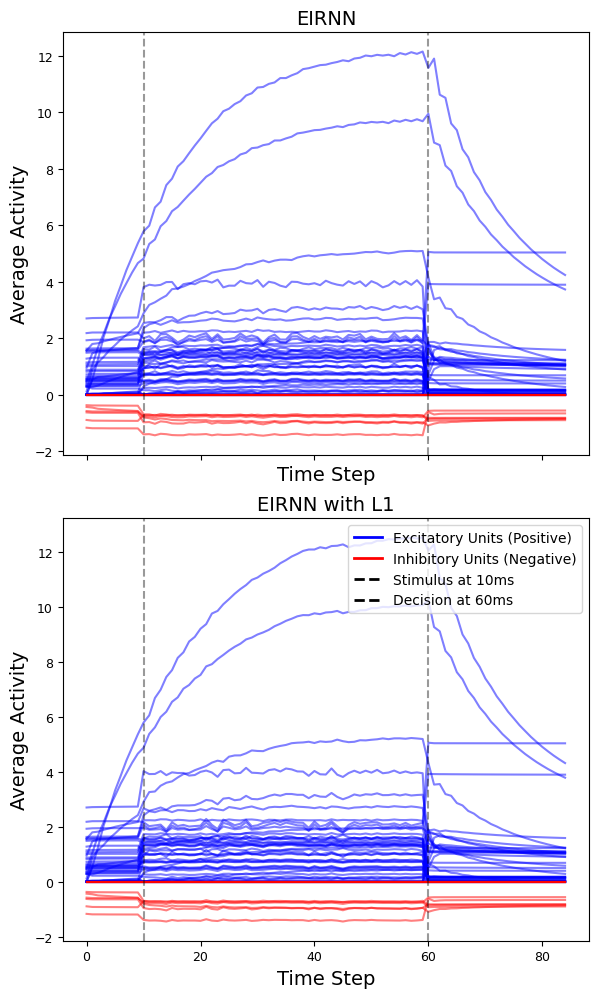

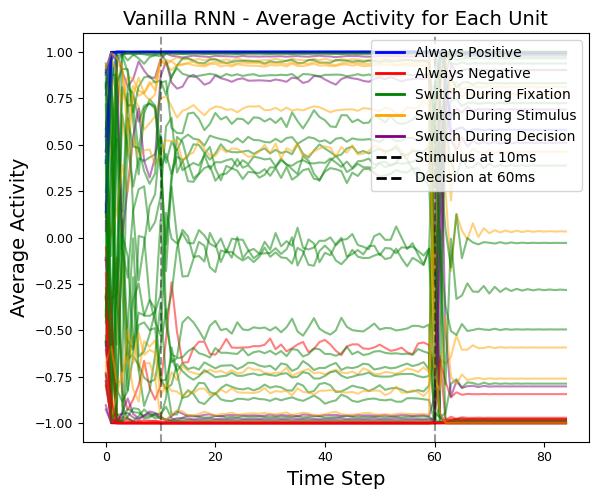

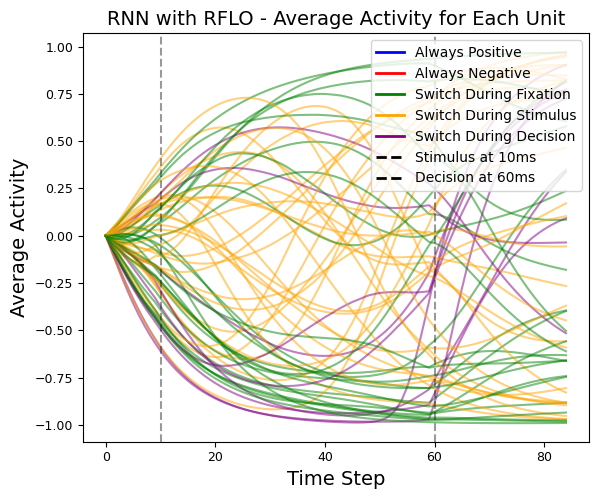

In [ ]:
def plot_average_unit_activity_colored_with_legend(
    activity_dicts, labels, timing=None, dt=None,
    title_fontsize=14, axis_label_fontsize=14, tick_label_fontsize=9, legend_fontsize=10
):
    """
    Plot the average activity over time for each unit across all trials,
    coloring units based on whether they are always positive, always negative,
    switch before stimulus (gray), switch between stimulus and decision (orange),
    or switch after decision (purple). Vertical lines mark the stimulus and decision phases.

    Args:
        activity_dicts: List of activity dictionaries for each model.
        labels: List of labels for each model (e.g., ['Leaky RNN', 'LSTM']).
        timing: Dictionary with 'fixation', 'stimulus', and 'decision' times in ms.
        dt: Time step size in ms.
        title_fontsize: Font size for subplot titles.
        axis_label_fontsize: Font size for x and y axis labels.
        tick_label_fontsize: Font size for tick labels.
        legend_fontsize: Font size for legend.
    """
    if timing is None or dt is None:
        raise ValueError("Both `timing` and `dt` must be provided.")

    # Calculate the transition points in terms of time steps
    stimulus_start = timing['fixation'] / dt
    decision_start = (timing['fixation'] + timing['stimulus']) / dt

    fig, axes = plt.subplots(len(activity_dicts), 1, figsize=(6, 5 * len(activity_dicts)), sharex=True)

    if len(activity_dicts) == 1:
        axes = [axes]  # Ensure axes is iterable for a single subplot

    for model_idx, (activity_dict, label) in enumerate(zip(activity_dicts, labels)):
        ax = axes[model_idx]

        # Aggregate all trials' activities into a single array
        all_activities = np.array([activity_dict[trial_idx] for trial_idx in activity_dict.keys()])  # Shape: (num_trials, time_steps, hidden_size)

        # Compute the mean activity for each unit across trials
        avg_unit_activity = np.mean(all_activities, axis=0)  # Shape: (time_steps, hidden_size)

        # Plot the activity of each unit with coloring based on its behavior
        for unit_idx in range(avg_unit_activity.shape[1]):  # Iterate over hidden units
            unit_activity = avg_unit_activity[:, unit_idx]

            # Determine the color based on the unit's behavior
            if np.all(unit_activity > 0):
                color = 'blue'  # Always positive
            elif np.all(unit_activity < 0):
                color = 'red'  # Always negative
            else:
                # Determine the first time step where the sign switches
                switch_points = np.where(np.diff(np.sign(unit_activity)) != 0)[0]

                if len(switch_points) > 0:
                    # Handle the case where the activity starts at 0
                    if unit_activity[0] == 0:
                        # Skip the first switch if it corresponds to the start
                        switch_points = switch_points[1:]

                    if len(switch_points) > 0:  # Re-check after removing the first switch
                        first_switch = switch_points[0]
                        if first_switch < stimulus_start:
                            color = 'green'  # Switches before stimulus
                        elif first_switch < decision_start:
                            color = 'orange'  # Switches between stimulus and decision
                        else:
                            color = 'purple'  # Switches after decision
                    else:
                        color = 'green'  # Default case if no valid switch points remain
                else:
                    color = 'green'  # Default case, unlikely but for robustness

            # Plot the unit activity
            ax.plot(unit_activity, color=color, alpha=0.5)

        # Add vertical lines for stimulus and decision phases
        ax.axvline(stimulus_start, color='black', linestyle='--', label='Stimulus', alpha=0.4)
        ax.axvline(decision_start, color='black', linestyle='--', label='Decision', alpha=0.4)

        # Add title and labels
        ax.set_title(f"{label} - Average Activity for Each Unit", fontsize=title_fontsize)
        ax.set_xlabel('Time Step', fontsize=axis_label_fontsize)
        ax.set_ylabel('Average Activity', fontsize=axis_label_fontsize)

        # Set tick label font size
        ax.tick_params(axis='both', labelsize=tick_label_fontsize)

        # Add a legend for the colors and the vertical lines
        legend_elements = [
            Line2D([0], [0], color='blue', lw=2, label='Always Positive'),
            Line2D([0], [0], color='red', lw=2, label='Always Negative'),
            Line2D([0], [0], color='green', lw=2, label='Switch During Fixation'),
            Line2D([0], [0], color='orange', lw=2, label='Switch During Stimulus'),
            Line2D([0], [0], color='purple', lw=2, label='Switch During Decision'),
            Line2D([0], [0], color='black', linestyle='--', lw=2, label=f'Stimulus at {stimulus_start:.0f}ms'),
            Line2D([0], [0], color='black', linestyle='--', lw=2, label=f'Decision at {decision_start:.0f}ms')
        ]
        ax.legend(handles=legend_elements, loc='upper right', fontsize=legend_fontsize)

    plt.tight_layout()
    plt.show()



def plot_eirnn_activities_colored(
    activity_dicts, models, titles, timing, dt,
    title_fontsize=14, axis_label_fontsize=14, tick_label_fontsize=9, legend_fontsize=10
):
    """
    Create vertically stacked subplots of average activity for multiple EIRNN models.

    Args:
        activity_dicts (list of dicts): List of activity dictionaries. Each dictionary contains
                                        trial indices as keys and arrays of shape
                                        (time_steps, hidden_size) as values.
        models (list): List of EIRNN models corresponding to the activity dictionaries.
        titles (list of str): Titles for each subplot.
        timing (dict): Timing dictionary with keys 'fixation' and 'stimulus'.
        dt (float): Time step in milliseconds.
        title_fontsize (int): Font size for subplot titles.
        axis_label_fontsize (int): Font size for axis labels.
        tick_label_fontsize (int): Font size for tick labels.
        legend_fontsize (int): Font size for the legend.

    Raises:
        ValueError: If the lengths of `activity_dicts`, `models`, and `titles` are not the same.
    """
    if len(activity_dicts) != len(models) or len(models) != len(titles):
        raise ValueError("The lengths of activity_dicts, models, and titles must be the same.")

    num_plots = len(activity_dicts)

    # Create stacked subplots
    fig, axes = plt.subplots(num_plots, 1, figsize=(6, 5 * num_plots), sharex=True)

    # Ensure axes is iterable for a single subplot
    if num_plots == 1:
        axes = [axes]

    # Calculate stimulus and decision times
    stimulus_start = timing['fixation'] / dt
    decision_start = (timing['fixation'] + timing['stimulus']) / dt

    for i, (activity_dict, model, title) in enumerate(zip(activity_dicts, models, titles)):
        ax = axes[i]

        # Define e_size (number of excitatory units) and total hidden size
        e_size = model.rnn.e_size  # Number of excitatory units
        i_size = model.rnn.hidden_size - e_size  # Number of inhibitory units

        # Aggregate all trials' activities into a single array
        all_activities = np.array([activity_dict[trial_idx] for trial_idx in activity_dict.keys()])  # (num_trials, time_steps, hidden_size)

        # Compute the mean activity for each unit across trials
        avg_unit_activity = np.mean(all_activities, axis=0)  # Shape: (time_steps, hidden_size)

        # Plot excitatory units in blue
        for unit_idx in range(e_size):
            ax.plot(avg_unit_activity[:, unit_idx], color='blue', alpha=0.5)

        # Plot inhibitory units in red
        for unit_idx in range(e_size, avg_unit_activity.shape[1]):
            ax.plot(-1 * avg_unit_activity[:, unit_idx], color='red', alpha=0.5)

        # Add vertical lines for stimulus and decision timings
        ax.axvline(stimulus_start, color='black', linestyle='--', alpha=0.4)
        ax.axvline(decision_start, color='black', linestyle='--', alpha=0.4)

        # Add title and labels with custom font sizes
        ax.set_title(title, fontsize=title_fontsize)
        ax.set_xlabel("Time Step", fontsize=axis_label_fontsize)
        ax.set_ylabel("Average Activity", fontsize=axis_label_fontsize)

        # Adjust tick label font size
        ax.tick_params(axis='both', labelsize=tick_label_fontsize)

    # Add a legend once for all plots
    legend_elements = [
        Line2D([0], [0], color='blue', lw=2, label='Excitatory Units (Positive)'),
        Line2D([0], [0], color='red', lw=2, label='Inhibitory Units (Negative)'),
        Line2D([0], [0], color='black', linestyle='--', lw=2, label=f'Stimulus at {stimulus_start:.0f}ms'),
        Line2D([0], [0], color='black', linestyle='--', lw=2, label=f'Decision at {decision_start:.0f}ms')
    ]
    axes[-1].legend(handles=legend_elements, loc='upper right', fontsize=legend_fontsize)

    plt.tight_layout()
    plt.show()



# plot_average_unit_activity_colored_with_legend(
#     [Vanilla_activity_dict, TCN_activity_dict, L1NormRNN_activity_dict, activity_dict_rflo, activity_dict_bptt],  # Activity dictionaries
#     ['Vanilla RNN', 'TCN RNN', 'L1Norm RNN', 'RNN with RFLO', 'RNN with BPTT'],  # Model labels
#     timing=timing,
#     dt=dt
# )

plot_eirnn_activities_colored([EIRNN_activity_dict, L1NormEIRNN_activity_dict],
                      [EIRNNNet, L1NormEIRNN],
                      ["EIRNN", "EIRNN with L1"],
                      timing,
                      dt)

plot_average_unit_activity_colored_with_legend(
    [Vanilla_activity_dict],  # Activity dictionaries
    ['Vanilla RNN'],  # Model labels
    timing=timing,
    dt=dt
)

plot_average_unit_activity_colored_with_legend(
    [activity_dict_rflo],  # Activity dictionaries
    ['RNN with RFLO'],  # Model labels
    timing=timing,
    dt=dt
)

# Extras didn't get round to using.

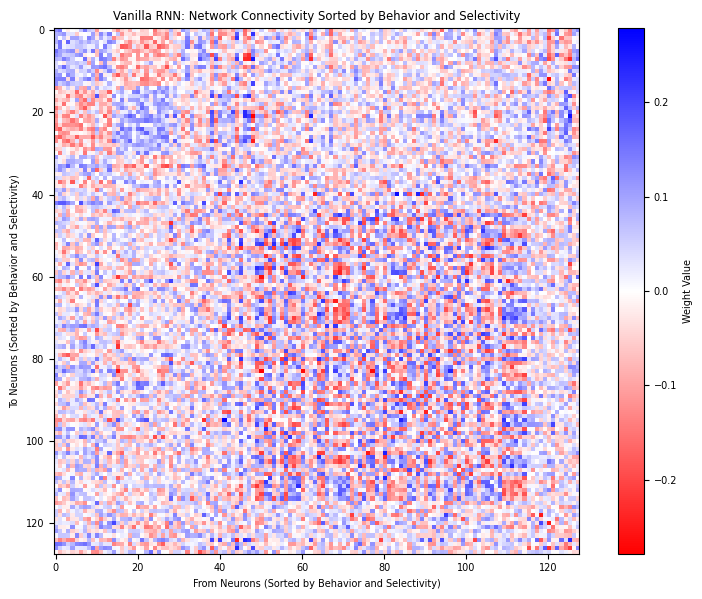

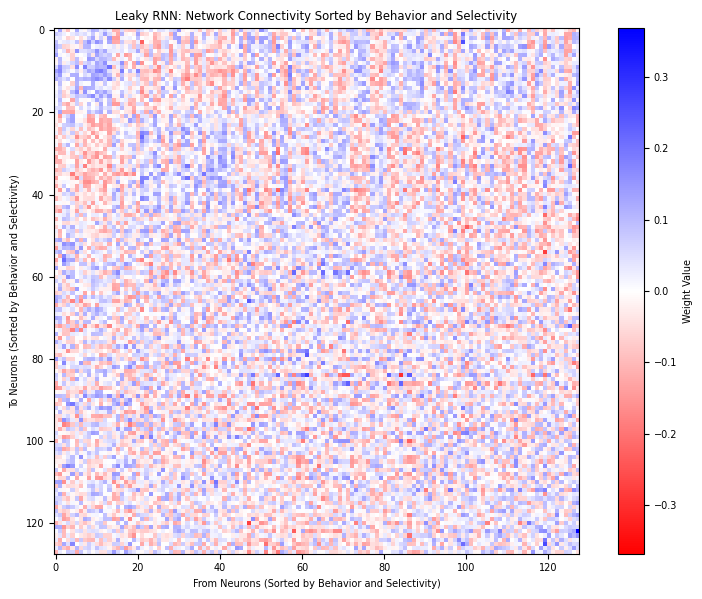

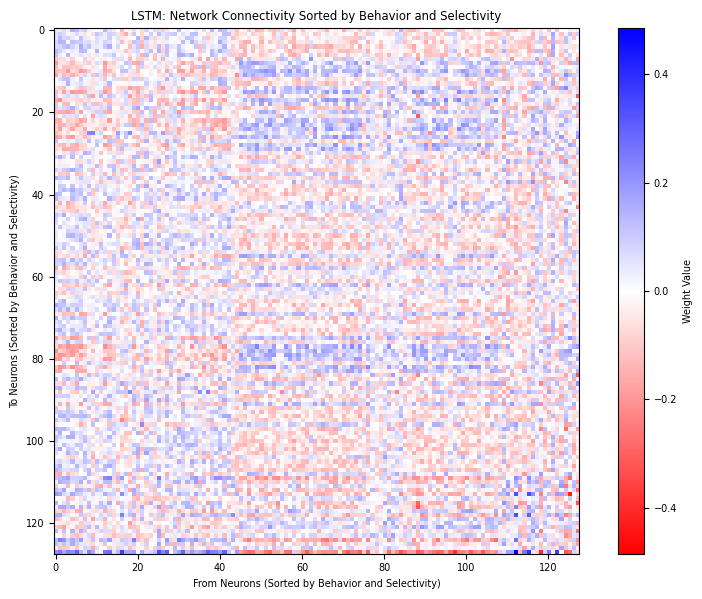

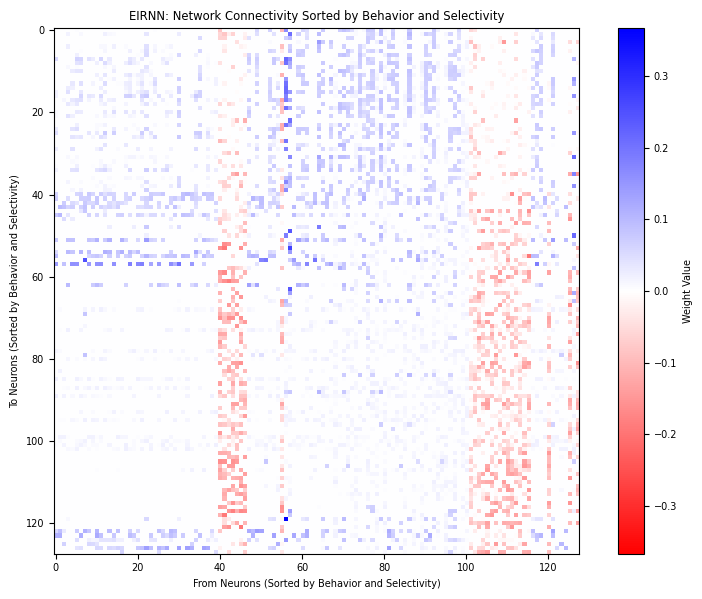

In [ ]:
# def compute_dprime_and_plot_connectivity(activity_dict, trial_infos, model, model_name, e_size=None):
#     """
#     Compute d-prime (selectivity) and plot sorted connectivity for a given model.

#     Args:
#         activity_dict: Dictionary mapping trial indices to hidden state activity arrays.
#         trial_infos: Dictionary mapping trial indices to trial metadata (e.g., ground_truth).
#         model: PyTorch model containing h2h weights.
#         model_name: Name of the model (e.g., 'Vanilla RNN', 'Leaky RNN').
#         e_size: Number of excitatory units (for EIRNN only, optional).
#     """
#     # Extract activity for ground_truth = 0 and 1
#     stim_activity = {0: [], 1: []}
#     for trial_idx, info in trial_infos.items():
#         ground_truth = info['ground_truth']
#         stim_activity[ground_truth].append(activity_dict[trial_idx])

#     # Compute mean and std for each ground truth
#     mean_activity = []
#     std_activity = []
#     for ground_truth in [0, 1]:
#         activity = np.concatenate(stim_activity[ground_truth], axis=0)  # (time_steps * trials, hidden_size)
#         mean_activity.append(np.mean(activity, axis=0))  # Mean across trials
#         std_activity.append(np.std(activity, axis=0))   # Std across trials

#     # Compute d-prime (selectivity)
#     selectivity = (mean_activity[0] - mean_activity[1])
#     selectivity /= np.sqrt((std_activity[0]**2 + std_activity[1]**2 + 1e-7) / 2)

#     # Sort indices by selectivity (separately for E and I if applicable)
#     if e_size is not None:
#         ind_sort = np.concatenate((np.argsort(selectivity[:e_size]), np.argsort(selectivity[e_size:]) + e_size))
#     else:
#         ind_sort = np.argsort(selectivity)

#     # Extract hidden-to-hidden connectivity matrix
#     if model.__class__.__name__ == "VanillaRNNNet":
#         W = model.hidden_to_hidden.weight.detach().numpy()
#     elif model.__class__.__name__ == "RNNNet":
#         W = model.rnn.hidden_to_hidden.weight.detach().numpy()
#     elif model.__class__.__name__ == "LSTMNet":
#         # For LSTM, extract hidden-to-hidden weights from the gates
#         W = model.lstm.weight_hh_l0.detach().numpy()
#     elif model.__class__.__name__ == "EIRNNNet":
#         W = model.rnn.h2h.effective_weight().detach().numpy()
#     else:
#         raise ValueError(f"Unsupported model type for {model_name}")

#     # Sort connectivity matrix by selectivity
#     W_sorted = W[:, ind_sort][ind_sort, :]  # Sort rows and columns

#     # Plot connectivity matrix
#     wlim = np.max(np.abs(W_sorted))
#     plt.figure(figsize=(8, 6))
#     plt.imshow(W_sorted, cmap='bwr_r', vmin=-wlim, vmax=wlim)
#     plt.colorbar(label='Weight Value')
#     plt.xlabel('From Neurons (Sorted by Selectivity)')
#     plt.ylabel('To Neurons (Sorted by Selectivity)')
#     plt.title(f'{model_name}: Network Connectivity Sorted by Selectivity')
#     plt.tight_layout()
#     plt.show()

def compute_dprime_and_plot_connectivity(activity_dict, trial_infos, model, model_name):
    """
    Compute d-prime (selectivity), sort units by behavior and selectivity, and plot the sorted connectivity matrix.

    Args:
        activity_dict: Dictionary mapping trial indices to hidden state activity arrays.
        trial_infos: Dictionary mapping trial indices to trial metadata (e.g., ground_truth).
        model: PyTorch model containing h2h weights.
        model_name: Name of the model (e.g., 'Vanilla RNN', 'Leaky RNN').
    """
    # Extract activity for ground_truth = 0 and 1
    stim_activity = {0: [], 1: []}
    for trial_idx, info in trial_infos.items():
        ground_truth = info['ground_truth']
        stim_activity[ground_truth].append(activity_dict[trial_idx])

    # Compute mean and std for each ground truth
    mean_activity = []
    std_activity = []
    for ground_truth in [0, 1]:
        activity = np.concatenate(stim_activity[ground_truth], axis=0)  # (time_steps * trials, hidden_size)
        mean_activity.append(np.mean(activity, axis=0))  # Mean across trials
        std_activity.append(np.std(activity, axis=0))   # Std across trials

    # Compute d-prime (selectivity)
    selectivity = (mean_activity[0] - mean_activity[1])
    selectivity /= np.sqrt((std_activity[0]**2 + std_activity[1]**2 + 1e-7) / 2)

    # Aggregate all trial activities into a single array
    all_activities = np.array([activity_dict[trial_idx] for trial_idx in activity_dict.keys()])  # (num_trials, time_steps, hidden_size)
    avg_unit_activity = np.mean(all_activities, axis=0)  # (time_steps, hidden_size)

    # Classify units based on behavior
    unit_categories = []
    for unit_idx in range(avg_unit_activity.shape[1]):  # Iterate over hidden units
        unit_activity = avg_unit_activity[:, unit_idx]
        if np.all(unit_activity > 0):
            unit_categories.append(('blue', unit_idx))  # Always positive (Ex: Excitatory)
        elif np.all(unit_activity < 0):
            unit_categories.append(('red', unit_idx))  # Always negative (Ex: Inhibitory)
        else:
            unit_categories.append(('gray', unit_idx))  # Other (Default)

    # Sort units by category: Excitatory -> Inhibitory -> Other
    sorted_indices = []
    for color in ['blue', 'red', 'gray']:
        category_indices = [idx for col, idx in unit_categories if col == color]
        # Sort within each category by selectivity
        sorted_indices.extend(sorted(category_indices, key=lambda x: selectivity[x]))




    # Extract hidden-to-hidden connectivity matrix
    if model.__class__.__name__ == "VanillaRNNNet":
        W = model.hidden_to_hidden.weight.detach().numpy()
    elif model.__class__.__name__ == "RNNNet":
        W = model.rnn.hidden_to_hidden.weight.detach().numpy()
    elif model.__class__.__name__ == "LSTMNet":
        # For LSTM, extract hidden-to-hidden weights from the gates
        W = model.lstm.weight_hh_l0.detach().numpy()
    elif model.__class__.__name__ == "EIRNNNet":
        W = model.rnn.h2h.effective_weight().detach().numpy()
    else:
        raise ValueError(f"Unsupported model type for {model_name}")

    # Sort connectivity matrix by behavior and selectivity
    W_sorted = W[:, sorted_indices][sorted_indices, :]  # Sort rows and columns

    # Plot connectivity matrix
    wlim = np.max(np.abs(W_sorted))
    plt.figure(figsize=(8, 6))
    plt.imshow(W_sorted, cmap='bwr_r', vmin=-wlim, vmax=wlim)
    plt.colorbar(label='Weight Value')
    plt.xlabel('From Neurons (Sorted by Behavior and Selectivity)')
    plt.ylabel('To Neurons (Sorted by Behavior and Selectivity)')
    plt.title(f'{model_name}: Network Connectivity Sorted by Behavior and Selectivity')
    plt.tight_layout()
    plt.show()




compute_dprime_and_plot_connectivity(
    Vanilla_activity_dict,
    Vanilla_trial_infos,
    VanillaRNNNet,
    model_name="Vanilla RNN"
)

compute_dprime_and_plot_connectivity(
    Leaky_activity_dict,
    Leaky_trial_infos,
    LeakyNet,
    model_name="Leaky RNN"
)
compute_dprime_and_plot_connectivity(
    LSTM_activity_dict,
    LSTM_trial_infos,
    LSTMNet,
    model_name="LSTM"
)
compute_dprime_and_plot_connectivity(
    EIRNN_activity_dict,
    EIRNN_trial_infos,
    EIRNNNet,
    model_name="EIRNN",
    # e_size=EIRNNNet.rnn.e_size  # Pass excitatory size for EIRNN
)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


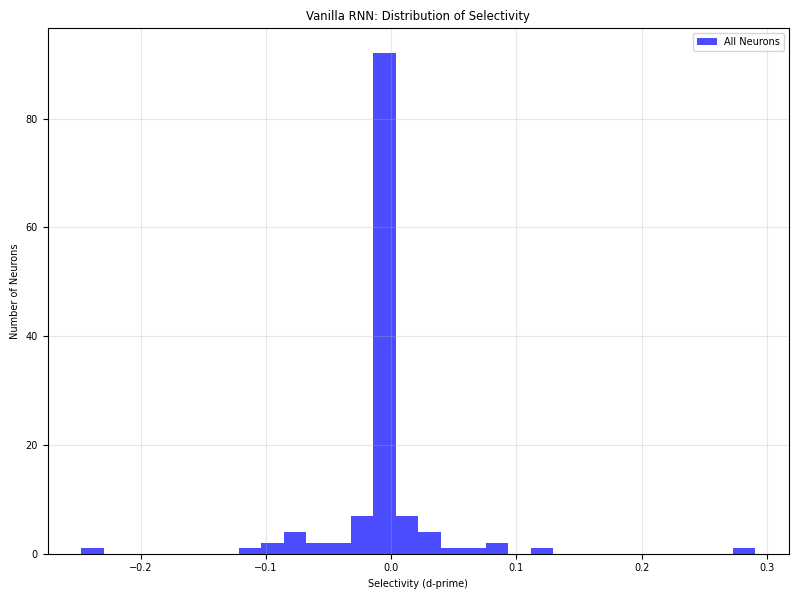

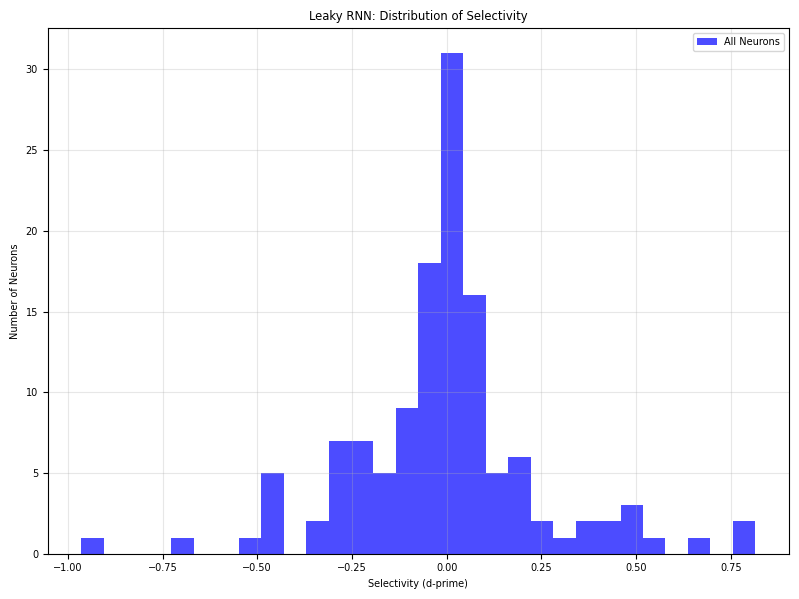

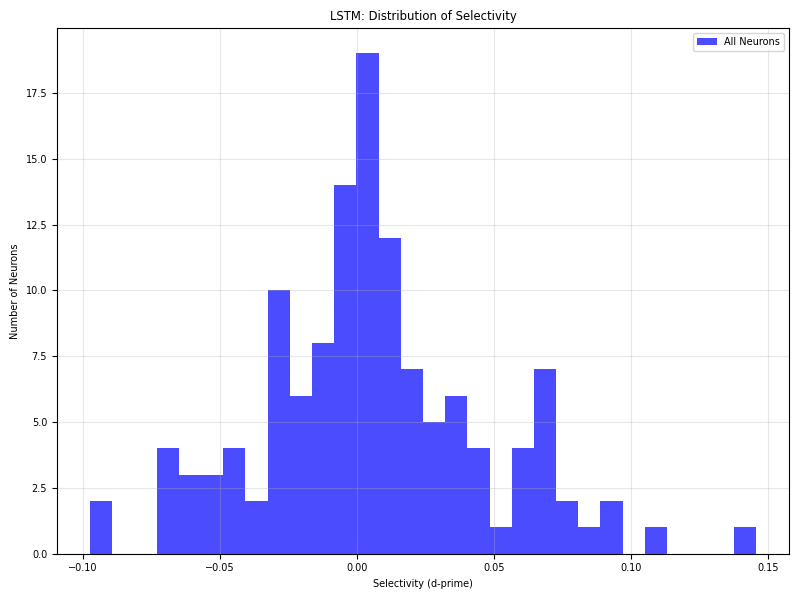

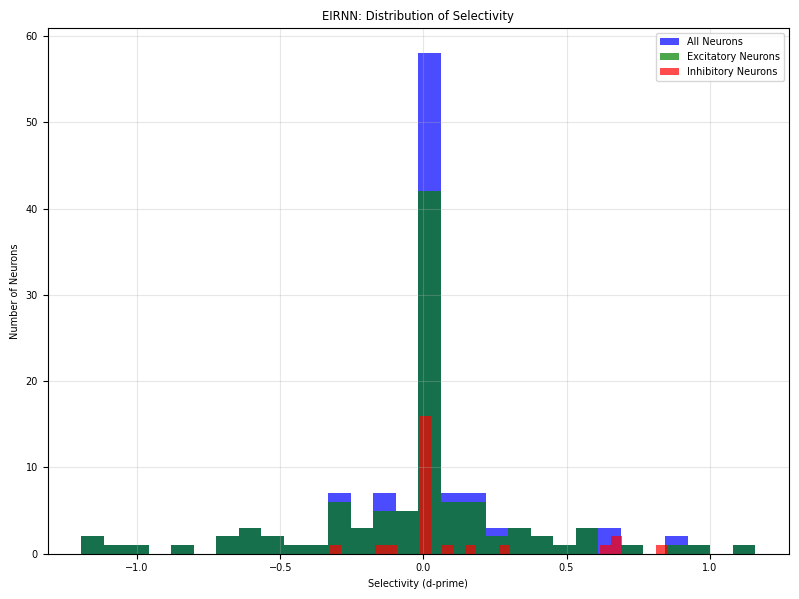

In [ ]:
def compute_dprime_and_plot_selectivity_distribution(activity_dict, trial_infos, model_name, e_size=None):
    """
    Compute d-prime (selectivity) and plot the distribution of selectivity for a given model.

    Args:
        activity_dict: Dictionary mapping trial indices to hidden state activity arrays.
        trial_infos: Dictionary mapping trial indices to trial metadata (e.g., ground_truth).
        model_name: Name of the model (e.g., 'Vanilla RNN', 'Leaky RNN').
        e_size: Number of excitatory units (for EIRNN only, optional).
    """
    # Extract activity for ground_truth = 0 and 1
    stim_activity = {0: [], 1: []}
    for trial_idx, info in trial_infos.items():
        ground_truth = info['ground_truth']
        stim_activity[ground_truth].append(activity_dict[trial_idx])

    # Compute mean and std for each ground truth
    mean_activity = []
    std_activity = []
    for ground_truth in [0, 1]:
        activity = np.concatenate(stim_activity[ground_truth], axis=0)  # (time_steps * trials, hidden_size)
        mean_activity.append(np.mean(activity, axis=0))  # Mean across trials
        std_activity.append(np.std(activity, axis=0))   # Std across trials

    # Compute d-prime (selectivity)
    selectivity = (mean_activity[0] - mean_activity[1])
    selectivity /= np.sqrt((std_activity[0]**2 + std_activity[1]**2 + 1e-7) / 2)

    # Plot the distribution of selectivity
    plt.figure(figsize=(8, 6))
    plt.hist(selectivity, bins=30, color='blue', alpha=0.7, label='All Neurons')

    # Highlight excitatory and inhibitory distributions separately if applicable
    if e_size is not None:
        plt.hist(selectivity[:e_size], bins=30, color='green', alpha=0.7, label='Excitatory Neurons')
        plt.hist(selectivity[e_size:], bins=30, color='red', alpha=0.7, label='Inhibitory Neurons')

    # Add labels, legend, and title
    plt.xlabel('Selectivity (d-prime)')
    plt.ylabel('Number of Neurons')
    plt.title(f'{model_name}: Distribution of Selectivity')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


compute_dprime_and_plot_selectivity_distribution(
    Vanilla_activity_dict,
    Vanilla_trial_infos,
    model_name="Vanilla RNN"
)

compute_dprime_and_plot_selectivity_distribution(
    Leaky_activity_dict,
    Leaky_trial_infos,
    model_name="Leaky RNN"
)

compute_dprime_and_plot_selectivity_distribution(
    LSTM_activity_dict,
    LSTM_trial_infos,
    model_name="LSTM"
)

compute_dprime_and_plot_selectivity_distribution(
    EIRNN_activity_dict,
    EIRNN_trial_infos,
    model_name="EIRNN",
    e_size=EIRNNNet.rnn.e_size  # Pass excitatory size for EIRNN
)




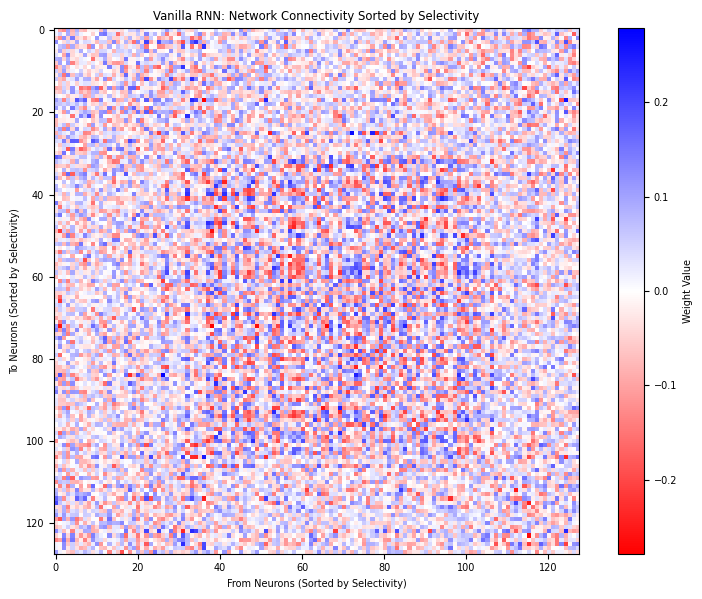

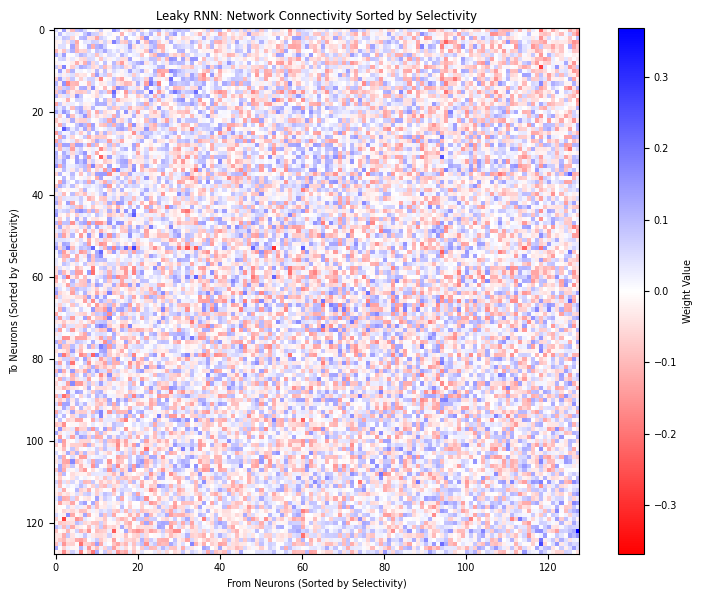

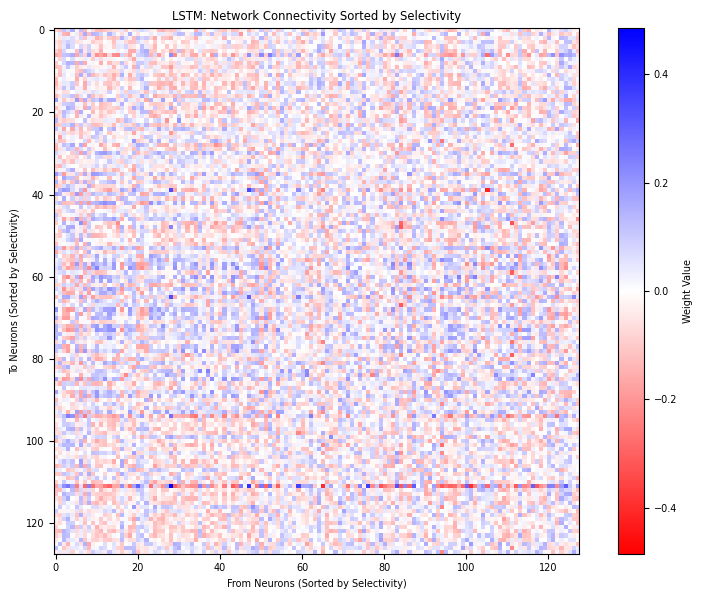

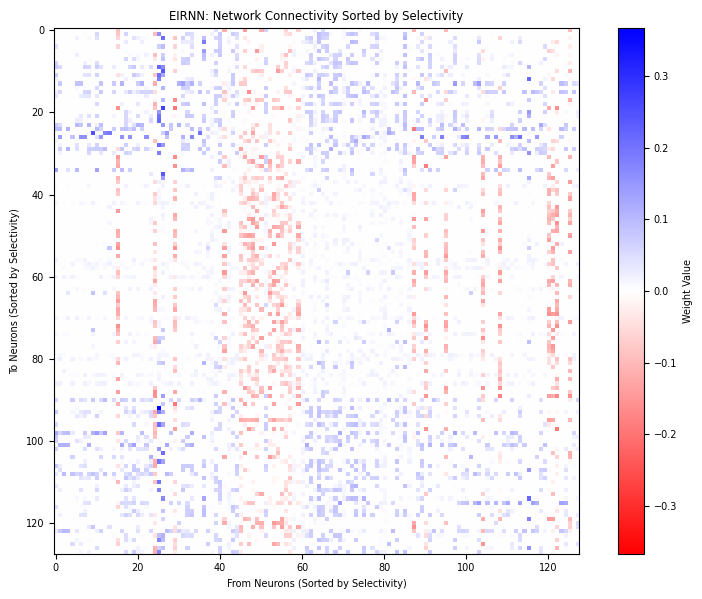

In [ ]:
def compute_dprime_and_plot_connectivity_by_selectivity(activity_dict, trial_infos, model, model_name):
    """
    Compute d-prime (selectivity) and plot connectivity matrix sorted by selectivity.

    Args:
        activity_dict: Dictionary mapping trial indices to hidden state activity arrays.
        trial_infos: Dictionary mapping trial indices to trial metadata (e.g., ground_truth).
        model: PyTorch model containing h2h weights.
        model_name: Name of the model (e.g., 'Vanilla RNN', 'Leaky RNN').
    """
    # Extract activity for ground_truth = 0 and 1
    stim_activity = {0: [], 1: []}
    for trial_idx, info in trial_infos.items():
        ground_truth = info['ground_truth']
        stim_activity[ground_truth].append(activity_dict[trial_idx])

    # Compute mean and std for each ground truth
    mean_activity = []
    std_activity = []
    for ground_truth in [0, 1]:
        activity = np.concatenate(stim_activity[ground_truth], axis=0)  # (time_steps * trials, hidden_size)
        mean_activity.append(np.mean(activity, axis=0))  # Mean across trials
        std_activity.append(np.std(activity, axis=0))   # Std across trials

    # Compute d-prime (selectivity)
    selectivity = (mean_activity[0] - mean_activity[1])
    selectivity /= np.sqrt((std_activity[0]**2 + std_activity[1]**2 + 1e-7) / 2)

    # Sort indices by selectivity
    ind_sort = np.argsort(selectivity)  # Ascending order of selectivity

    # Extract hidden-to-hidden connectivity matrix
    if model.__class__.__name__ == "VanillaRNNNet":
        W = model.hidden_to_hidden.weight.detach().numpy()
    elif model.__class__.__name__ == "RNNNet":
        W = model.rnn.hidden_to_hidden.weight.detach().numpy()
    elif model.__class__.__name__ == "LSTMNet":
        # For LSTM, extract hidden-to-hidden weights from the gates
        W = model.lstm.weight_hh_l0.detach().numpy()
    elif model.__class__.__name__ == "EIRNNNet":
        W = model.rnn.h2h.effective_weight().detach().numpy()
    else:
        raise ValueError(f"Unsupported model type for {model_name}")

    # Sort connectivity matrix by selectivity
    W_sorted = W[:, ind_sort][ind_sort, :]  # Sort rows and columns

    # Plot connectivity matrix
    wlim = np.max(np.abs(W_sorted))
    plt.figure(figsize=(8, 6))
    plt.imshow(W_sorted, cmap='bwr_r', vmin=-wlim, vmax=wlim)
    plt.colorbar(label='Weight Value')
    plt.xlabel('From Neurons (Sorted by Selectivity)')
    plt.ylabel('To Neurons (Sorted by Selectivity)')
    plt.title(f'{model_name}: Network Connectivity Sorted by Selectivity')
    plt.tight_layout()
    plt.show()

compute_dprime_and_plot_connectivity_by_selectivity(
    Vanilla_activity_dict,
    Vanilla_trial_infos,
    VanillaRNNNet,
    model_name="Vanilla RNN"
)

compute_dprime_and_plot_connectivity_by_selectivity(
    Leaky_activity_dict,
    Leaky_trial_infos,
    LeakyNet,
    model_name="Leaky RNN"
)
compute_dprime_and_plot_connectivity_by_selectivity(
    LSTM_activity_dict,
    LSTM_trial_infos,
    LSTMNet,
    model_name="LSTM"
)
compute_dprime_and_plot_connectivity_by_selectivity(
    EIRNN_activity_dict,
    EIRNN_trial_infos,
    EIRNNNet,
    model_name="EIRNN",
    # e_size=EIRNNNet.rnn.e_size  # Pass excitatory size for EIRNN
)


In [ ]:
!pip install git+https://github.com/OverLordGoldDragon/see-rnn

  Cloning https://github.com/OverLordGoldDragon/see-rnn to /tmp/pip-req-build-auasuia_
  Running command git clone --filter=blob:none --quiet https://github.com/OverLordGoldDragon/see-rnn /tmp/pip-req-build-auasuia_
  Resolved https://github.com/OverLordGoldDragon/see-rnn to commit 4346a1db4ebe549cb923134afa2735604632a37e
  Preparing metadata (setup.py) ... done
  Created wheel for see-rnn: filename=see_rnn-1.15.2-py3-none-any.whl size=36560 sha256=76405b0b3d9774915ab850771d5d4d09005672489f131910306061315420cc9f
  Stored in directory: /tmp/pip-ephem-wheel-cache-bzmwtd85/wheels/88/9f/c0/32a8ad172f8187093e096e14ca1a6d455ae5d891bf1b716495
Successfully built see-rnn


In [ ]:
"""Module to quick-test various See RNN functionalities"""
import os
import tensorflow as tf
import numpy as np

os.environ['TF_KERAS'] = "1"  # configurable
os.environ['TF_EAGER'] = "0"  # configurable

print("TF version:", tf.__version__)

TF_2 = (tf.__version__[0] == '2')
eager_default = "1" if TF_2 else "0"
TF_EAGER = bool(os.environ.get('TF_EAGER', eager_default) == "1")
TF_KERAS = bool(os.environ.get('TF_KERAS', "0") == "1")

if TF_EAGER:
    if not TF_2:
        tf.enable_eager_execution()
    print("TF running eagerly")
else:
    if TF_2:
        tf.compat.v1.disable_eager_execution()
    print("TF running in graph mode")

if TF_KERAS:
    import tensorflow.keras.backend as K
    from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Bidirectional
    # from tensorflow.compat.v1.keras.layers import CuDNNLSTM, CuDNNGRU  # [1]
    from tensorflow.keras.models import Model
    from tensorflow.keras.optimizers import Adam
else:
    import keras.backend as K
    from keras.layers import Input, LSTM, GRU, SimpleRNN, Bidirectional
    # from keras.layers import CuDNNLSTM, CuDNNGRU  # [1]: uncomment if using GPU
    from keras.models import Model
    from keras.optimizers import Adam

from see_rnn import get_gradients, get_outputs, get_rnn_weights
from see_rnn import features_0D, features_1D, features_2D
from see_rnn import rnn_heatmap, rnn_histogram

###############################################################################
def make_model(rnn_layer, batch_shape, units=8, bidirectional=False):
    ipt = Input(batch_shape=batch_shape)
    if bidirectional:
        x = Bidirectional(rnn_layer(units, return_sequences=True,))(ipt)
    else:
        x = rnn_layer(units, return_sequences=True)(ipt)
    out = rnn_layer(units, return_sequences=False)(x)

    model = Model(ipt, out)
    model.compile(Adam(lr=1e-2), 'mse')
    return model

def make_data(batch_shape, units):
    return (np.random.randn(*batch_shape),
            np.random.uniform(-1, 1, (batch_shape[0], units)),
            np.random.uniform(0, 2, batch_shape[0]))

def train_model(model, iterations):
    batch_shape = K.int_shape(model.input)
    units = model.layers[2].units
    x, y, sw = make_data(batch_shape, units)

    for i in range(iterations):
        model.train_on_batch(x, y, sw)
        print(end='.')  # progbar
        if i % 40 == 0:
            x, y, sw = make_data(batch_shape, units)

def viz_outs(model, idx=1):
    x, y, _ = make_data(K.int_shape(model.input), model.layers[2].units)
    outs = get_outputs(model, idx, x)

    features_1D(outs[:1], n_rows=8, show_borders=False)
    features_2D(outs,     n_rows=8, norm=(-1,1))

def viz_weights(model, idx=1):
    rnn_histogram(model, idx, mode='weights', bins=400)
    print('\n')
    rnn_heatmap(model,   idx, mode='weights', norm='auto')

def viz_outs_grads(model, idx=1):
    x, y, _ = make_data(K.int_shape(model.input), model.layers[2].units)
    grads = get_gradients(model, idx, x, y)
    kws = dict(n_rows=8, title='grads')

    features_1D(grads[0], show_borders=False, **kws)
    features_2D(grads,    norm=(-1e-4, 1e-4), **kws)

def viz_outs_grads_last(model, idx=2):  # return_sequences=False layer
    x, y, _ = make_data(K.int_shape(model.input), model.layers[2].units)
    grads = get_gradients(model, idx, x, y)
    features_0D(grads)

def viz_weights_grads(model, idx=1):
    x, y, _ = make_data(K.int_shape(model.input), model.layers[2].units)
    kws = dict(_id=idx, input_data=x, labels=y)

    rnn_histogram(model, mode='grads', bins=400, **kws)
    print('\n')
    rnn_heatmap(model,   mode='grads', cmap=None, absolute_value=True, **kws)

def viz_prefetched_data(model, data, idx=1):
    rnn_histogram(model, idx, data=data)
    rnn_heatmap(model,   idx, data=data)

###############################################################################
units = 64
batch_shape = (32, 100, 16)

model = make_model(LSTM, batch_shape, units)
train_model(model, 50)

viz_outs(model, 1)
viz_outs_grads(model, 1)
viz_outs_grads_last(model, 2)
viz_weights(model, 1)
viz_weights_grads(model, 1)

data = get_rnn_weights(model, 1)
viz_prefetched_data(model, data, 1)

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation


TF version: 2.17.1
TF running in graph mode


ValueError: Argument(s) not recognized: {'lr': 0.01}

In [ ]:
from re import L
def analyze_gradients_filtered(net, dataset, exclude_params=None):
    """
    Evaluate gradients for a single batch from the dataset.
    Optionally exclude specified parameters from analysis.
    """
    exclude_params = exclude_params or []
    net.eval()  # Set the model to evaluation mode
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float32).to(device)
    labels = torch.from_numpy(labels.flatten()).type(torch.long).to(device)

    # Forward pass
    outputs, _ = net(inputs)  # Unpack output and hidden states
    outputs = outputs.view(-1, output_size)

    # Define a dummy loss for backpropagation
    criterion = nn.CrossEntropyLoss()
    loss = criterion(outputs, labels)

    # Backward pass
    net.zero_grad()
    loss.backward()

    # Capture gradient norms, excluding specified parameters
    gradient_norms = []
    for name, param in net.named_parameters():
        if name not in exclude_params and param.grad is not None:
            gradient_norm = param.grad.data.norm(2).item()
            gradient_norms.append((name, gradient_norm))

    return gradient_norms

vanilla_gradients = analyze_gradients_filtered(VanillaRNNNet, easy_dataset)
TCNRNN_gradients = analyze_gradients_filtered(TCNRNN, easy_dataset)
EIRNN_gradients = analyze_gradients_filtered(EIRNNNet, easy_dataset)
L1NormRNN_gradients = analyze_gradients_filtered(L1NormRNN, easy_dataset)
RFLORNN_gradients = analyze_gradients_filtered(rflo_rnn, easy_dataset)

# Prepare gradient norms and parameter names
vanilla_grad_norms = [norm for _, norm in vanilla_gradients]
TCNRNN_grad_norms = [norm for _, norm in TCNRNN_gradients]
EIRNN_grad_norms = [norm for _, norm in EIRNN_gradients]
L1NormRNN_grad_norms = [norm for _, norm in L1NormRNN_gradients]
rflo_grad_norms = [norm for _, norm in RFLORNN_gradients]
param_names = [name for name, _ in vanilla_gradients]  # Shared parameter names across models

# Plot gradient norms
x = np.arange(len(param_names))


plt.figure(figsize=(12, 6))
plt.plot(x, vanilla_grad_norms, label='Vanilla RNN', marker='o', alpha=0.7)
plt.plot(x, TCNRNN_grad_norms, label='TCNRNN', marker='o', alpha=0.7)
plt.plot(x, EIRNN_grad_norms, label='EIRNN', marker='o', alpha=0.7)
plt.plot(x, L1NormRNN_grad_norms, label='L1Norm RNN', marker='o', alpha=0.7)
plt.plot(x, rflo_grad_norms, label='RFLO RNN', marker='o', alpha=0.7)
plt.xticks(x, param_names, rotation=90)
plt.xlabel('Model Parameters')
plt.ylabel('Gradient Norm')
plt.title('Gradient Norms of Trained Models (Excluding rnn.alpha)')
plt.legend()
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TypeError: Module.eval() missing 1 required positional argument: 'self'